## Objective

This project tackles a regression task from Kaggle focused on predicting the selling price of used cars using structured data. 

In this project, I will cover:

* Data cleaning and feature engineering (e.g., encoding, imputation, scaling)
* Model training with **Linear Regression**, **Ridge**, **XGBoost**, and **LightGBM**, evaluated with and without **PCA**
* Model evaluation using **R²**, **MAE**, **RMSE**, and overfit gap analysis
* Best model selection based on lowest **RMSE** on validation data
* Final model saved via `pickle` and applied to Kaggle's `test.csv`
* Submission generated in the required format

This notebook delivers a complete solution from preprocessing through to final submission.

## Dataset

The dataset used in this project is sourced from the Kaggle competition: [Playground Series - Season 4, Episode 9](https://www.kaggle.com/competitions/playground-series-s4e9/overview).

It includes training and testing sets related to used car listings, designed for regression-based price prediction.

Each row represents an individual car listing with several key attributes:

* **id**: Unique identifier for each listing
* **brand**: Car manufacturer name
* **model**: Specific model of the vehicle
* **model_year**: Manufacturing year of the vehicle
* **milage**: Total kilometers driven
* **fuel_type**: Type of fuel used (gasoline, diesel, electric, hybrid)
* **engine**: Engine specifications
* **transmission**: Transmission type (automatic, manual, etc.)
* **ext_col**: Exterior color
* **int_col**: Interior color
* **accident**: Whether the car has a history of accidents or damage
* **clean_title**: Indicates if the vehicle holds a clean title, which can impact the vehicle's resale value and legal status
* **price**: Resale price of the car (target variable, only in train.csv)

## Import libraries

In [1]:
from datetime import date
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import math
import pickle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Data Preprocessing

### 1.1 Load the dataset and perform basic cleaning (handle missing values, duplicates).

In [620]:
# Define file paths of the datasets
train_path = "train.csv"
test_path = "test.csv"

# Load datasets into pandas DataFrames
train_df_raw = pd.read_csv(train_path)
test_df_raw = pd.read_csv(test_path)
submission = pd.read_csv("sample_submission.csv")

In [323]:
# Display first 5 rows
train_df_raw.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [324]:
# Display first 5 rows
test_df_raw.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [325]:
# Check data types and non-null counts
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [326]:
# Check data types and non-null counts
test_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [327]:
# Check statistics summary
train_df_raw.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [328]:
# Check statistics summary
test_df_raw.describe()

,id,model_year,milage
count,125690.000000,125690.000000,125690.000000
mean,251377.500000,2015.797526,66042.581510
std,36283.722005,5.673797,50223.858435
min,188533.000000,1974.000000,100.000000
25%,219955.250000,2013.000000,24500.000000
50%,251377.500000,2017.000000,57500.000000
75%,282799.750000,2020.000000,95798.000000
max,314222.000000,2024.000000,405000.000000


In [329]:
# Check missing values for each column
train_df_raw.isna().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5083
engine,0
transmission,0
ext_col,0
int_col,0


In [330]:
# Check missing values for each column
test_df_raw.isna().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,3383
engine,0
transmission,0
ext_col,0
int_col,0


**Observations from initial analysis of both datasets:**

* The training set contains 188,533 records, while the test set contains 125,690 records.

* From train_df,

    * There are 5083 missing values in `fuel_type` and 2452 in `accident`.

    * Meanwhile, `clean_title` has 21419 missing records. I will further analyze whether to drop these records or replace them.

* From test_df,

    * 3383 missing `fuel_type` records and 1632 missing `accident` records.

    * Whereas, there are 14239 missing records in `clean_title`.

<Axes: >

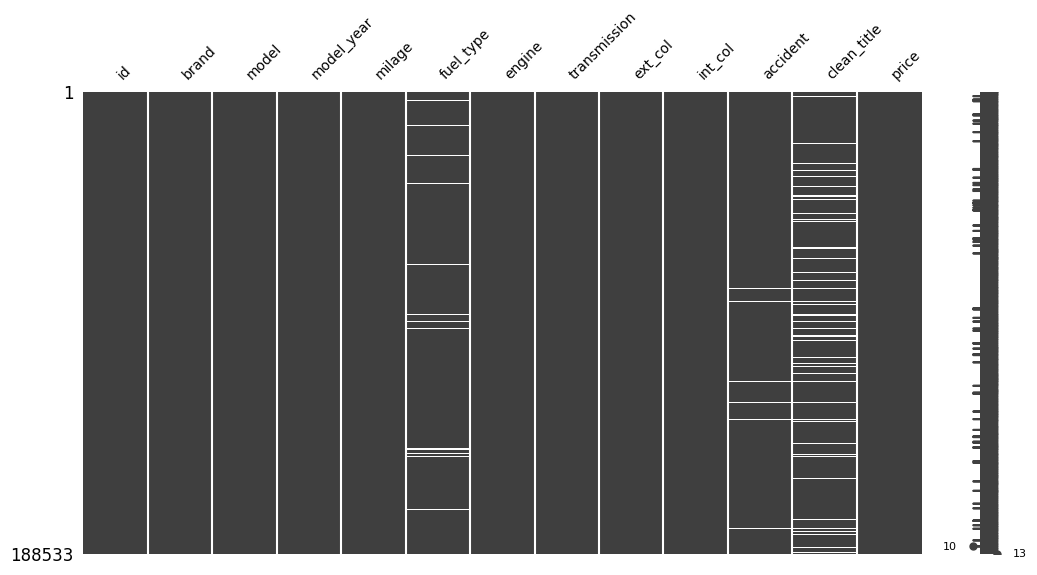

In [331]:
# Visualize missing values
msno.matrix(train_df_raw, figsize=(12, 6), fontsize=10)

<Axes: >

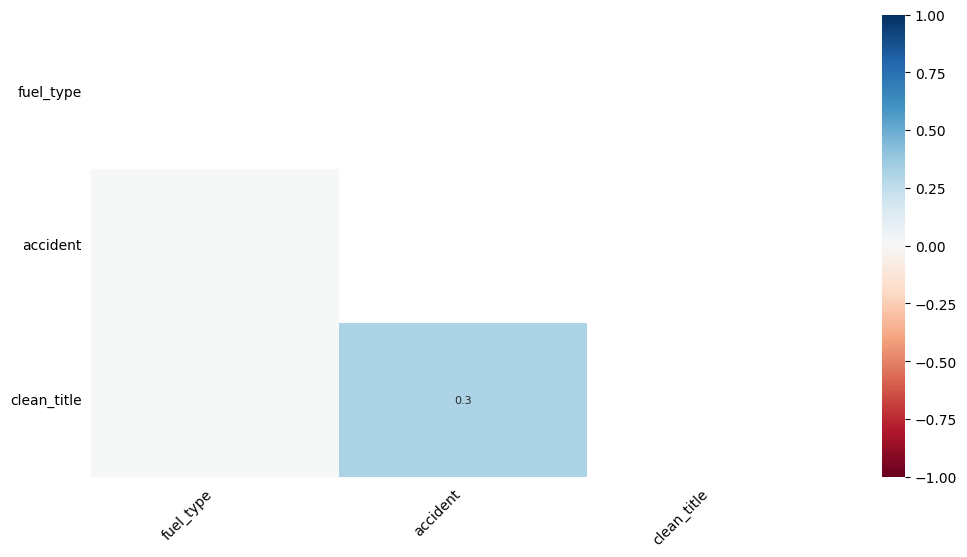

In [332]:
msno.heatmap(train_df_raw, figsize=(12, 6), fontsize=10)

**Observations from missing value matrix and heatmap:**

* The matrix shows missing values mostly occur independently across `fuel_type`, `accident`, and `clean_title`.

* From the heatmap, only `accident` and `clean_title` have a weak correlation (0.3), meaning some overlap in missing rows, but nothing strong enough to suggest joint imputation.

* So, I’ll handle missing values for each column separately.

In [333]:
# Verify unique values in the missing columns
missing_columns = train_df_raw.columns[train_df_raw.isna().any()]

for col in missing_columns:
    print(f"Unique values count of {col}: {train_df_raw[col].nunique()}")
    print(f"{train_df_raw[col].unique()}\n")

Unique values count of fuel_type: 7
['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']

Unique values count of accident: 2
['None reported' 'At least 1 accident or damage reported' nan]

Unique values count of clean_title: 1
['Yes' nan]



In [334]:
for col in missing_columns:
    print(f"Value counts of {col}: {train_df_raw[col].value_counts()}\n")

Value counts of fuel_type: fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

Value counts of accident: accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

Value counts of clean_title: clean_title
Yes    167114
Name: count, dtype: int64



# Basic cleaning

In [352]:
# Copy train and test df
train_df = train_df_raw.copy()
test_df = test_df_raw.copy()

In [353]:
# Strip and lower model values
original_n_unique = train_df['model'].nunique()
cleaned_n_unique = train_df['model'].astype(str).str.strip().str.lower().nunique()

print(f"Before cleaning: {original_n_unique} unique values")
print(f"After cleaning:  {cleaned_n_unique} unique values")

Before cleaning: 1897 unique values
After cleaning:  1893 unique values


**Observations from unqiue values and counts:**

* All three columns that have missing values are categorical.

    * `fuel_type` has 7 unique values. Among them, `–` (781 records) and `not supported` (15 records) don't indicate valid fuel types. So, I’ll treate them as invalid fuel types alongside the missing values, and replace with `Unknown`.

    * `accident` has only two values, `None reported` and `At least 1 accident or damage reported`. Since `None Reported` has 144,514 rows, I will leave them as-is, and I’ll fill missing values with `Unknown`.

    * `clean_title` only has `Yes`. Since there’s no alternative value, I’ll treat missing records as `Unknown`.

**Strategy for cleaning and standardizing cols**

* I created a function that will

    * strip white spaces and lowercase everything inside categorical columns

    * standardize `fuel_type`, `accident` and `clean_title` columns as I stated above.

* After that, I called that function using both train_df and test_df to get a return of cleaned datasets.

In [355]:
# Create function to clean and standardize columns
def clean_categorical_columns(df):
    df = df.copy()

    # Define cat cols
    categorical_cols = df.select_dtypes(include=['object', 'string']).columns

    # Strip, lowercase, and clean string 'nan'
    for col in categorical_cols:
        df[col] = df[col].astype(str).str.strip().str.lower()
        df[col] = df[col].replace('nan', np.nan)  # Convert string 'nan' to real np.nan

    # Define valid fuel types
    valid_fuels = {'gasoline', 'hybrid', 'e85 flex fuel', 'plug-in hybrid'}

    # Replace invalid or missing fuel_type with 'unknown'
    if 'fuel_type' in df.columns:
        df['fuel_type'] = df['fuel_type'].apply(lambda x: x if x in valid_fuels else 'unknown')

    # Replace missing values in 'accident'
    if 'accident' in df.columns:
        df['accident'] = df['accident'].fillna('unknown')
        df['accident'] = df['accident'].replace({
            'at least 1 accident or damage reported': 'reported',
            'none reported': 'none'
        })

    # Replace missing values in 'clean_title'
    if 'clean_title' in df.columns:
        df['clean_title'] = df['clean_title'].fillna('unknown')

    return df

In [377]:
# Call function to clean both datasets
train_df = clean_categorical_columns(train_df)
test_df = clean_categorical_columns(test_df)

In [378]:
# Verify again
print(train_df.isna().sum())
print(test_df.isna().sum())

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type           0
engine              0
transmission        0
ext_col             0
int_col             0
accident            0
clean_title         0
price               0
car_age             0
mileage_per_year    0
dtype: int64
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type           0
engine              0
transmission        0
ext_col             0
int_col             0
accident            0
clean_title         0
car_age             1
mileage_per_year    1
dtype: int64


In [358]:
# Print unique values of each cat col
cat_cols = train_df.select_dtypes(include=['object', 'string']).columns

for col in cat_cols:
    print(f"\nTop unique values in '{col}':")
    print(train_df[col].value_counts(dropna=False).to_frame(name='count').head(10))
    print(f"\Bottom unique values in '{col}':")
    print(train_df[col].value_counts(dropna=False).to_frame(name='count').tail(10))


Top unique values in 'brand':
               count
brand               
ford           23088
mercedes-benz  19172
bmw            17028
chevrolet      16335
audi           10887
porsche        10612
land            9525
toyota          8850
lexus           8643
jeep            6474
\Bottom unique values in 'brand':
          count
brand          
lotus        52
fiat         44
saab         22
karma        17
suzuki        8
plymouth      7
polestar      7
bugatti       7
smart         3
maybach       3

Top unique values in 'model':
                      count
model                      
f-150 xlt              2945
m3 base                2229
camaro 2ss             1709
m4 base                1622
mustang gt premium     1526
f-150 lariat           1410
e-class e 350 4matic   1357
1500 laramie           1249
911 carrera s          1219
corvette base          1184
\Bottom unique values in 'model':
                               count
model                               
forte lx        

In [360]:
# Check full row duplicates
print(train_df.duplicated().sum())

# Check full row duplicates
print(test_df.duplicated().sum())

0
0


In [361]:
# Define columns to check (except id and price)
to_check = train_df.columns.difference(['id', 'price'])

# Check count of every duplicated row including first occurrence
print(train_df.duplicated(subset=to_check, keep=False).sum())

# Print duplicated rows
train_df[train_df.duplicated(subset=to_check, keep=False)]

2


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
58891,58891,ram,1500 laramie,2022,76249,gasoline,5.7l v8 16v mpfi ohv,8-speed automatic,diamond black,black,none,yes,49685
75505,75505,ram,1500 laramie,2022,76249,gasoline,5.7l v8 16v mpfi ohv,8-speed automatic,diamond black,black,none,yes,36250


In [368]:
# Keep the first unique row, and drop the rest
train_df = train_df[~train_df.duplicated(subset=to_check, keep='first')]

# Check duplicate counts again
print(train_df.duplicated(subset=to_check, keep=False).sum())

0


**Observations from duplicate checks:**

* Using `train_df.duplicated().sum()`, I found 0 exact duplicates across all columns.

* However, when I checked a subset of columns ('brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'), and left target column behind, I found 2 duplicated records.

* When I print those records, I found that all subset columns have same vlaues, except for id and price.

* So, I kept only the first unique row, and dropped the second record. After that, I checked the dupolicate counts again, and found 0.

### 1.2 Create a new feature: `car_age = current_year - year`.

In [369]:
# Get current year using date.today().year
current_year = date.today().year
print(current_year)

2025


In [370]:
# Check unique values of model year
train_df['model_year'].unique()

array([2007, 2002, 2017, 2021, 2018, 2016, 2020, 2015, 2011, 2013, 2023,
       2019, 2012, 2014, 2008, 2009, 2022, 2003, 2005, 2001, 2006, 2000,
       2010, 2004, 1997, 1998, 1999, 1994, 1993, 1996, 1995, 2024, 1974,
       1992])

In [371]:
# Create new column to calculate car age
train_df['car_age'] = current_year - train_df['model_year']
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age
0,0,mini,cooper s base,2007,213000,gasoline,172.0hp 1.6l 4 cylinder engine gasoline fuel,a/t,yellow,gray,none,yes,4200,18
1,1,lincoln,ls v8,2002,143250,gasoline,252.0hp 3.9l 8 cylinder engine gasoline fuel,a/t,silver,beige,reported,yes,4999,23
2,2,chevrolet,silverado 2500 lt,2002,136731,e85 flex fuel,320.0hp 5.3l 8 cylinder engine flex fuel capab...,a/t,blue,gray,none,yes,13900,23
3,3,genesis,g90 5.0 ultimate,2017,19500,gasoline,420.0hp 5.0l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,black,black,none,yes,45000,8
4,4,mercedes-benz,metris base,2021,7388,gasoline,208.0hp 2.0l 4 cylinder engine gasoline fuel,7-speed a/t,black,beige,none,yes,97500,4


In [372]:
# Do the same for test_df
test_df['car_age'] = current_year - test_df['model_year']
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,car_age
0,188533,land,rover lr2 base,2015,98000,gasoline,240.0hp 2.0l 4 cylinder engine gasoline fuel,6-speed a/t,white,beige,none,yes,10
1,188534,land,rover defender se,2020,9142,hybrid,395.0hp 3.0l straight 6 cylinder engine gasoli...,8-speed a/t,silver,black,none,yes,5
2,188535,ford,expedition limited,2022,28121,gasoline,3.5l v6 24v pdi dohc twin turbo,10-speed automatic,white,ebony,none,unknown,3
3,188536,audi,a6 2.0t sport,2016,61258,gasoline,2.0 liter tfsi,automatic,silician yellow,black,none,unknown,9
4,188537,audi,a6 2.0t premium plus,2018,59000,gasoline,252.0hp 2.0l 4 cylinder engine gasoline fuel,a/t,gray,black,none,yes,7


In [375]:
# Create new feature mileage per car_age
train_df['car_age'] = current_year - train_df['model_year']
train_df['car_age'] = train_df['car_age'].clip(lower=1)  # minimum 1 year

# Calculate mileage per year
train_df['mileage_per_year'] = train_df['milage'] / train_df['car_age']
print(train_df['mileage_per_year'].head())

0    11833.333333
1     6228.260870
2     5944.826087
3     2437.500000
4     1847.000000
Name: mileage_per_year, dtype: float64


In [379]:
# Do the same for test_df
test_df['car_age'] = current_year - test_df['model_year']
test_df['car_age'] = test_df['car_age'].clip(lower=1)
test_df['mileage_per_year'] = test_df['milage'] / test_df['car_age']
print(test_df['mileage_per_year'].head())

0    9800.000000
1    1828.400000
2    9373.666667
3    6806.444444
4    8428.571429
Name: mileage_per_year, dtype: float64


### 1.3 Drop irrelevant features like `car_name` if present.

In [380]:
# Check the column names
print(train_df.columns)
print(test_df.columns)

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'car_age', 'mileage_per_year'],
      dtype='object')
Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'car_age', 'mileage_per_year'],
      dtype='object')


In [381]:
# Drop irrelevant columns
train_df.drop(['model_year', 'id'], axis=1, inplace=True, errors='ignore')
test_df.drop(['model_year', 'id'], axis=1, inplace=True, errors='ignore')

In [382]:
# Verify columns again
print(train_df.columns)
print(test_df.columns)

Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'car_age',
       'mileage_per_year'],
      dtype='object')
Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'car_age',
       'mileage_per_year'],
      dtype='object')


### 1.4 Convert categorical variables using One-Hot Encoding or Label Encoding.

**Strategy for high-cardinality categorical features**

* For high-cardinality categorical features like `brand`, `model`, `engine`, etc., I decided to keep only the top frequent values.

* Everything outside the top N (based on frequency) is grouped under `'other'` to reduce dimensionality and noise.

* This helps control the number of one-hot encoded columns and avoids overfitting from rare categories.

* I applied the same logic consistently across `transmission`, `ext_col`, and `int_col` as well, just to keep the encoding space clean.

In [383]:
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

print(train_df[categorical_cols].nunique().sort_values(ascending=False))

model           1893
engine          1117
ext_col          317
int_col          152
brand             57
transmission      51
fuel_type          5
accident           3
clean_title        2
dtype: int64


#### Filter and group 'brand'

**Approach for `brand`**

* I checked the frequency of each brand and found that only a handful have strong representation in the data.

* To simplify the encoding and avoid overfitting from rare brands, I grouped all brands with less than 2000 records into a single category called `'other'`.

* This keeps the one-hot encoded space cleaner and focuses the model on brands that actually have enough signal.

* I applied the same logic to both train and test sets to keep it consistent.

In [384]:
print("Top values (brand):")
print(train_df['brand'].value_counts().head(10))

print("\nRare or weird values (brand):")
print(train_df['brand'].value_counts().tail(10))

Top values (brand):
brand
ford             23088
mercedes-benz    19172
bmw              17028
chevrolet        16335
audi             10887
porsche          10612
land              9525
toyota            8850
lexus             8643
jeep              6474
Name: count, dtype: int64

Rare or weird values (brand):
brand
lotus       52
fiat        44
saab        22
karma       17
suzuki       8
plymouth     7
polestar     7
bugatti      7
smart        3
maybach      3
Name: count, dtype: int64


In [385]:
# Define threshold for filtering common brands
threshold = 1000

# Get frequency count of each brand in training set
brand_counts = train_df['brand'].value_counts()

# Get list of brands that meet or exceed the threshold
common_brands = brand_counts[brand_counts >= threshold].index.tolist()

# Replace rare brands with 'other' in both train and test sets
train_df['brand_grp'] = train_df['brand'].apply(lambda x: x if x in common_brands else 'other')
test_df['brand_grp'] = test_df['brand'].apply(lambda x: x if x in common_brands else 'other')

In [386]:
# Verify the new cols
print(train_df['brand_grp'].value_counts())
print("------------------")
print(test_df['brand_grp'].value_counts())

brand_grp
ford             23088
mercedes-benz    19172
bmw              17028
chevrolet        16335
audi             10887
porsche          10612
other             9953
land              9525
toyota            8850
lexus             8643
jeep              6474
cadillac          4674
ram               4248
nissan            3930
tesla             3738
infiniti          3276
gmc               3215
dodge             3133
mazda             2719
kia               2497
lincoln           2423
subaru            2381
acura             2282
honda             2101
hyundai           2045
volkswagen        1765
jaguar            1319
bentley           1155
mini              1064
Name: count, dtype: int64
------------------
brand_grp
ford             15265
mercedes-benz    12875
bmw              11286
chevrolet        10698
audi              7289
porsche           7153
other             6733
land              6348
toyota            6084
lexus             5729
jeep              4412
cadillac       

#### Filter and group 'model'

**Strategy for `model`**

* I extracted the first two tokens from the original `model` name to create a simplified `model_base`, since full model names are too detailed and inconsistent.

* From that, I selected the top 100 most frequent `model_base` values based on their counts in the training set.

* All other less common or noisy model names were grouped under `'other'` to reduce dimensionality and avoid overfitting.

* I applied this grouping to both train and test sets.

In [387]:
# Extract first two tokens as model_base
train_df['model_base'] = train_df['model'].str.split().str[:2].str.join(' ')
test_df['model_base'] = test_df['model'].str.split().str[:2].str.join(' ')

# Select top 100 frequent models from model_base
top_models = train_df['model_base'].value_counts().nlargest(100).index

# Group model_base
train_df['mdl_grp'] = train_df['model_base'].apply(lambda x: x if x in top_models else 'other')
test_df['mdl_grp'] = test_df['model_base'].apply(lambda x: x if x in top_models else 'other')

In [388]:
# Verify the new cols
print(train_df['mdl_grp'].value_counts())
print("------------------")
print(test_df['mdl_grp'].value_counts())

mdl_grp
other               90901
rover range          7647
911 carrera          3905
f-150 xlt            3228
e-class e            3170
                    ...  
escalade premium      422
ls 460                421
a8 l                  417
mx-5 miata            416
wrangler sahara       411
Name: count, Length: 101, dtype: int64
------------------
mdl_grp
other               61179
rover range          5148
911 carrera          2552
f-150 xlt            2125
e-class e            2034
                    ...  
escalade premium      279
mx-5 miata            268
golf gti              265
mustang premium       260
fusion se             259
Name: count, Length: 101, dtype: int64


#### Extract new features from 'engine'

**Strategy for parsing `engine`**

* The `engine` column contains free-text data with mixed formats like horsepower, engine size, cylinder count, and occassionally fuel type.

* I wrote a custom function to extract structured features from that text:

  * `engine_hp` (e.g. 450hp)
  * `engine_size` (e.g. 4.0L)
  * `engine_cyl` (e.g. 8 cylinder)
  * `engine_fuel_type` (if text contains "engine" or "motor", take the trailing token), etc.

* For any patterns not matched, I left the value as `None` so I can handle missing values explicitly later.

* I applied this transformation to both train and test sets to create clean numeric features out of messy text.

In [389]:
print("Top values (engine):")
print(train_df['engine'].value_counts().head(20))

print("\nRare or weird values (engine):")
print(train_df['engine'].value_counts().tail(20))

Top values (engine):
engine
355.0hp 5.3l 8 cylinder engine gasoline fuel             3462
240.0hp 2.0l 4 cylinder engine gasoline fuel             2902
420.0hp 6.2l 8 cylinder engine gasoline fuel             2841
2.0l i4 16v gdi dohc turbo                               2680
375.0hp 3.5l v6 cylinder engine gasoline fuel            2451
340.0hp 3.0l v6 cylinder engine gasoline fuel            2436
490.0hp 6.2l 8 cylinder engine gasoline fuel             2187
455.0hp 6.2l 8 cylinder engine gasoline fuel             2138
425.0hp 3.0l straight 6 cylinder engine gasoline fuel    2134
300.0hp 3.0l straight 6 cylinder engine gasoline fuel    2084
295.0hp 3.5l v6 cylinder engine gasoline fuel            1917
285.0hp 3.6l v6 cylinder engine gasoline fuel            1910
302.0hp 3.5l v6 cylinder engine gasoline fuel            1895
3.5l v6 24v pdi dohc twin turbo                          1842
301.0hp 4.6l 8 cylinder engine gasoline fuel             1578
5.7l v8 16v mpfi ohv                      

**Based on the results, I can see some pattern in engine col**

* Rows with horsepower "HP" tend to be structured and include:

  * Xhp, Yl, Z cylinder, "engine", and fuel info

  * These are usually cleaner and more informative

* Rows without HP are more descriptive, e.g.,

  * 2.0l i4 16v gdi dohc turbo
  * 3.5l v6 24v pdi dohc twin turbo
  * 5.7l v8 16v mpfi ohv

  * These records don't have "engine" keyword and have no numeric HP

  * Instead they have
    * engine size (2.0l, 3.5l, etc.)
    * engine layouts (i4, v6, v8, etc.)
    * valves (16v, 24v etc.)
    * fuel injection system (gdi, pdi, mpfi, etc.)
    * valve train types (DOHC, SOHC, OHV, etc.)
    * aspiration info (e.g., trubo, twin turbo, supercharged)
    


In [390]:
train_df[
    train_df['engine'].str.contains(r'\d+\.?\d*\s*l', case=False, na=False) &
    ~train_df['engine'].str.contains(r'hp', case=False, na=False)
]['engine'].unique()

array(['2.7l v6 24v pdi dohc twin turbo', '5.2l v10 40v pdi dohc',
       '3.6l v6 24v gdi dohc', '4.0l v8 32v gdi dohc twin turbo',
       '5.7l v8 16v mpfi ohv', '3.0l v6 24v gdi dohc twin turbo',
       '3.8l v8 32v mpfi dohc twin turbo',
       '3.4l v6 24v pdi dohc twin turbo hybrid',
       '3.5l v6 24v pdi dohc twin turbo', '2.0l i4 16v pdi dohc turbo',
       '2.4l i4 16v gdi dohc', '2.0 liter dohc turbo',
       '3.6l v6 24v mpfi dohc', '6.0l v8 16v mpfi ohv flexible fuel',
       '2.0l i4 16v gdi dohc turbo', '2.3l i4 16v gdi dohc turbo',
       '5.3l v8 16v gdi ohv', '2.0 liter', '3.0l v6 24v gdi dohc turbo',
       '3.8l v6 24v gdi dohc', '3.8l h6 24v gdi dohc twin turbo',
       '2.0 liter turbo', '3.0 liter turbo', '2.0 liter tfsi',
       '3.5 liter', '2.5l h4 16v mpfi dohc',
       '4.4l v8 32v gdi dohc twin turbo', '5.6 liter',
       '4.6l v8 32v mpfi dohc', '4.0l v8 32v mpfi dohc twin turbo',
       '2.5l i4 16v gdi dohc', '3.6l v6 24v mpfi dohc hybrid',
       '2.0l

In [391]:
# Function that will standardize engine column a
def clean_engine_column(df):
    return (
        df['engine']
        .astype(str)
        .str.lower()
        .str.replace('litre', 'l', regex=False) # convert litre to l
        .str.replace('liter', 'l', regex=False) # convert liter to l
        .str.replace(r'(\d+\.?\d*)\s*l', r'\1l', regex=True)  # normalize space before 'l'
        .str.strip()
    )

In [392]:
train_df['engine_clean'] = clean_engine_column(train_df)
test_df['engine_clean'] = clean_engine_column(test_df)

In [393]:
# Subset 1: Engine strings that contain 'hp'
df_with_hp = train_df[train_df['engine_clean'].str.contains('hp', case=False, na=False)]

# Subset 2: Engine strings that contain 'l' (liter) but NOT 'hp'
df_with_l_only = train_df[
    train_df['engine_clean'].str.contains(r'\d+\.?\d*l', case=False, na=False) &
    ~train_df['engine_clean'].str.contains('hp', case=False, na=False)
]

# Name the subsets
subset_hp = df_with_hp.copy()
subset_l = df_with_l_only.copy()

In [394]:
# Print total recs
print("No. of records in subset_hp", len(subset_hp))

# Print common values
print("Most common values:\n")
print(subset_hp['engine_clean'].value_counts().head(20))
print()
print("Least common values:\n")
print(subset_hp['engine_clean'].value_counts().tail(20))

No. of records in subset_hp 155274
Most common values:

engine_clean
355.0hp 5.3l 8 cylinder engine gasoline fuel             3462
240.0hp 2.0l 4 cylinder engine gasoline fuel             2902
420.0hp 6.2l 8 cylinder engine gasoline fuel             2841
375.0hp 3.5l v6 cylinder engine gasoline fuel            2451
340.0hp 3.0l v6 cylinder engine gasoline fuel            2436
490.0hp 6.2l 8 cylinder engine gasoline fuel             2187
455.0hp 6.2l 8 cylinder engine gasoline fuel             2138
425.0hp 3.0l straight 6 cylinder engine gasoline fuel    2134
300.0hp 3.0l straight 6 cylinder engine gasoline fuel    2084
295.0hp 3.5l v6 cylinder engine gasoline fuel            1917
285.0hp 3.6l v6 cylinder engine gasoline fuel            1910
302.0hp 3.5l v6 cylinder engine gasoline fuel            1895
301.0hp 4.6l 8 cylinder engine gasoline fuel             1578
268.0hp 3.5l v6 cylinder engine gasoline fuel            1470
333.0hp 3.0l v6 cylinder engine gasoline fuel            1319
3

In [395]:
# Print total recs
print("No. of records in subset_l", len(subset_l))

# Print common values
print("Most common values:\n")
print(subset_l['engine_clean'].value_counts().head(20))
print()
print("Least common values:\n")
print(subset_l['engine_clean'].value_counts().tail(20))

No. of records in subset_l 31187
Most common values:

engine_clean
2.0l i4 16v gdi dohc turbo         2680
3.5l v6 24v pdi dohc twin turbo    1842
5.7l v8 16v mpfi ohv               1539
4.0l v8 32v gdi dohc twin turbo    1516
3.6l v6 24v mpfi dohc              1480
3.6l v6 24v gdi dohc               1224
2.0l turbo                         1164
5.3l v8 16v gdi ohv                1011
2.5l i4 16v gdi dohc                898
3.0l turbo                          823
3.5l v6 24v pdi dohc                814
3.0l                                793
6.2l v8 16v gdi ohv                 728
2.0l                                636
3.0l v6 24v gdi dohc twin turbo     635
2.0l tfsi                           610
3.5l                                565
3.8l v6 24v gdi dohc                395
4.4l twin turbo                     364
4.4l v8 32v gdi dohc twin turbo     324
Name: count, dtype: int64

Least common values:

engine_clean
6.4l v8 32v ddi ohv twin turbo diesel    13
4.2l v8 32v gdi dohc       

In [396]:
def get_text_after_engine_keyword(text):
    if pd.isna(text) or not isinstance(text, str):
        return np.nan
    text_lower = text.lower()

    # Prioritize "electric motor"
    match_electric = re.search(r'electric motor\s*(.*)', text_lower)
    if match_electric:
        return match_electric.group(1).strip()

    # Fallback to "engine"
    match_engine = re.search(r'engine\s*(.*)', text_lower)
    if match_engine:
        return match_engine.group(1).strip()

    return np.nan # If neither keyword is found

In [397]:
eng_desc_hp = subset_hp['engine_clean'].apply(get_text_after_engine_keyword)
eng_desc_l = subset_l['engine_clean'].apply(get_text_after_engine_keyword)
print(eng_desc_hp.value_counts(dropna=False))
print()
print(eng_desc_l.value_counts(dropna=False))

engine_clean
gasoline fuel                    136056
flex fuel capability               5168
electric fuel system               4680
diesel fuel                        3686
gasoline/mild electric hybrid      3573
gas/electric hybrid                1558
plug-in electric/gas                537
hydrogen fuel                        16
Name: count, dtype: int64

engine_clean
NaN              31077
gasoline fuel      105
diesel fuel          5
Name: count, dtype: int64


In [398]:
def extract_hp_features(text):
    """
    Extracts structured engine features from a raw engine description string,
    with enhanced parsing for fuel and engine types.

    Parameters:
        text (str): Raw engine description (e.g., '355.0hp 5.3l 8 cylinder engine gasoline fuel')

    Returns:
        pd.Series: A pandas Series with the following extracted fields:
            - engine_hp (float): Horsepower value
            - engine_size (float): Engine displacement in liters
            - engine_cyl (int): Number of cylinders
            - engine_layout (str): Layout type (e.g., 'v6', 'straight 6', 'i4')
            - engine_fuel_type_raw (str): The raw fuel description captured
            - engine_fuel_type_categorized (str): Categorized fuel type (e.g., 'Gasoline', 'Diesel', 'Electric', 'Hybrid', 'Other')
    """
    if pd.isna(text) or not isinstance(text, str):
        text_lower = "" # Handle NaN or non-string inputs gracefully
    else:
        text_lower = str(text).lower()

    # Extract basic features
    hp_match = re.search(r'(\d+\.?\d*)hp', text_lower)
    l_match = re.search(r'(\d+\.?\d*)l', text_lower)
    cyl_match = re.search(r'(\d+) cylinder', text_lower)
    layout_match = re.search(r'(v\d|straight \d|i\d)', text_lower)

    # Extract Fuel and Engine Type
    raw_fuel_description = np.nan
    categorized_fuel_type = np.nan

    # Define patterns
    fuel_phrase_map = {
        'plug-in electric/gas': 'hybrid',
        'gasoline/mild electric hybrid': 'hybrid',
        'gas/electric hybrid': 'hybrid',
        'electric fuel system': 'electric',
        'flex fuel capability': 'flex fuel',
        'diesel fuel': 'diesel',
        'gasoline fuel': 'gasoline',
        'hydrogen fuel': 'hydrogen'
    }

    sorted_phrases = sorted(fuel_phrase_map.keys(), key=len, reverse=True)

    for phrase in sorted_phrases:
        if phrase in text_lower:
            engine_fuel_type_raw = phrase
            categorized_fuel_type = fuel_phrase_map[phrase]
            break

    extracted_cyl = int(cyl_match.group(1)) if cyl_match else np.nan
    extracted_layout = layout_match.group(1) if layout_match else np.nan

    if pd.isna(extracted_cyl) and not pd.isna(extracted_layout):
        layout_num_match = re.search(r'\d+', extracted_layout)
        if layout_num_match:
            extracted_cyl = int(layout_num_match.group(0))

    return pd.Series({
        'engine_hp': float(hp_match.group(1)) if hp_match else np.nan,
        'engine_size': float(l_match.group(1)) if l_match else np.nan,
        'engine_cyl': extracted_cyl,
        'engine_layout': extracted_layout,
        'engine_fuel_type_raw': engine_fuel_type_raw,
        'engine_fuel_type_categorized': categorized_fuel_type
    })

In [399]:
def extract_engine_features(text):
    if pd.isna(text) or not isinstance(text, str):
        text_lower = ""
    else:
        text_lower = str(text).lower()

    # Extract Engine Features
    hp_match = re.search(r'(\d+\.?\d*)hp', text_lower)
    l_match = re.search(r'(\d+\.?\d*)l', text_lower)
    cyl_match = re.search(r'(\d+) cylinder', text_lower)
    # layout_match = re.search(r'(v\d|straight \d|i\d)', text_lower)
    layout_match = re.search(r'(v\d|straight \d|i\d|h\d|w\d|inline \d|boxer)', text_lower)
    valves_match = re.search(r'(\d{2})v', text_lower) # e.g., 16v, 24v, 32v
    inject_match = re.search(r'\b(gdi|pdi|mpfi|ddi)\b', text_lower) # e.g., gdi, mpfi
    valve_train_match = re.search(r'\b(dohc|sohc|ohv)\b', text_lower) # e.g., dohc, ohv
    aspiration_match = re.search(r'(twin turbo|turbo|supercharged|naturally aspirated)', text_lower) # Added 'naturally aspirated' for completeness

    # Initialize Fuel and Engine Type Variables
    engine_fuel_type_raw = np.nan
    categorized_fuel_type = np.nan

    # Define Fuel Phrase Mapping
    fuel_phrase_map = {
        'plug-in electric/gas': 'plug-in hybrid',
        'gasoline/mild electric hybrid': 'hybrid',
        'gas/electric hybrid': 'hybrid',
        'electric fuel system': 'electric',
        'flex fuel capability': 'flex fuel',
        'diesel fuel': 'diesel',
        'gasoline fuel': 'gasoline',
        'hydrogen fuel': 'hydrogen',
        'petrol fuel': 'gasoline',
        'ethanol fuel': 'flex fuel',
        'natural gas': 'cng/lpg',
        'cng': 'cng/lpg',
        'lpg': 'cng/lpg'
    }

    sorted_phrases = sorted(fuel_phrase_map.keys(), key=len, reverse=True)

    # Loop to Extract Categorized Fuel Type
    for phrase in sorted_phrases:
        if phrase in text_lower:
            engine_fuel_type_raw = phrase
            categorized_fuel_type = fuel_phrase_map[phrase]
            break

    # Refine engine_fuel_type_raw if still NaN after direct mapping
    if pd.isna(engine_fuel_type_raw) and not pd.isna(categorized_fuel_type) and categorized_fuel_type != 'Unknown':
        engine_fuel_type_raw = categorized_fuel_type.lower() + " type" if categorized_fuel_type not in ['Electric', 'Hydrogen', 'CNG/LPG'] else categorized_fuel_type.lower()


    # Handle engine_cyl inference from layout
    extracted_cyl = int(cyl_match.group(1)) if cyl_match else np.nan
    extracted_layout = layout_match.group(1) if layout_match else np.nan

    if pd.isna(extracted_cyl) and not pd.isna(extracted_layout):
        layout_num_match = re.search(r'\d+', extracted_layout)
        if layout_num_match:
            extracted_cyl = int(layout_num_match.group(0))

    # Return the Series with all extracted and inferred features
    return pd.Series({
        'engine_hp': float(hp_match.group(1)) if hp_match else np.nan,
        'engine_size': float(l_match.group(1)) if l_match else np.nan,
        'engine_cyl': extracted_cyl,
        'engine_layout': extracted_layout,
        'engine_fuel_type_raw': engine_fuel_type_raw,
        'engine_fuel_type_categorized': categorized_fuel_type,
        'engine_valves': int(valves_match.group(1)) if valves_match else np.nan,
        'engine_injection_type': inject_match.group(1) if inject_match else np.nan,
        'engine_valvetrain': valve_train_match.group(1) if valve_train_match else np.nan,
        'engine_aspiration': aspiration_match.group(1) if aspiration_match else np.nan
    })

In [400]:
# Apply function on subset_hp
extracted_features_hp = subset_hp['engine_clean'].apply(extract_engine_features)

# Print most common values across new features
for col in extracted_features_hp.columns:
    print(f"\nTop values for {col}:")
    print(extracted_features_hp[col].value_counts(dropna=False).head(20))


Top values for engine_hp:
engine_hp
300.0    5416
355.0    4433
420.0    4020
240.0    3634
400.0    3518
375.0    3191
425.0    2976
340.0    2718
455.0    2707
302.0    2675
295.0    2636
310.0    2577
335.0    2562
210.0    2407
395.0    2278
285.0    2257
490.0    2187
333.0    1988
270.0    1952
325.0    1787
Name: count, dtype: int64

Top values for engine_size:
engine_size
3.0    22408
3.5    18007
2.0    17267
6.2     9983
4.0     8619
3.6     6906
5.3     5461
5.0     5436
2.5     4947
3.8     4677
NaN     4627
5.7     4574
4.6     3872
4.4     3458
3.7     3448
2.4     2865
4.7     2776
2.7     2409
6.0     2031
6.7     2029
Name: count, dtype: int64

Top values for engine_cyl:
engine_cyl
6.0     66296
8.0     52444
4.0     29037
NaN      4767
12.0     1258
10.0      698
5.0       627
3.0       147
Name: count, dtype: int64

Top values for engine_layout:
engine_layout
NaN           94322
v6            49312
straight 6    11640
Name: count, dtype: int64

Top values for engine

In [401]:
# Apply function on subset_l
extracted_features_l = subset_l['engine_clean'].apply(extract_engine_features)

# Print most common values across new features
for col in extracted_features_l.columns:
    print(f"\nTop values for {col}:")
    print(extracted_features_l[col].value_counts(dropna=False).head(20))


Top values for engine_hp:
engine_hp
NaN    31187
Name: count, dtype: int64

Top values for engine_size:
engine_size
2.0    5856
3.5    4141
3.0    3550
3.6    3120
4.0    2384
2.5    1931
5.7    1628
5.3    1043
6.2     885
4.4     856
5.0     672
3.8     624
2.4     516
6.7     459
5.2     416
2.7     323
2.3     323
5.6     271
1.5     248
4.6     248
Name: count, dtype: int64

Top values for engine_cyl:
engine_cyl
6.0    9235
NaN    7591
8.0    7059
4.0    6095
1.0     951
3.0     256
Name: count, dtype: int64

Top values for engine_layout:
engine_layout
v6     8251
NaN    7749
v8     6915
i4     5945
v1      794
h6      667
i6      317
i3      256
w1      157
h4      136
Name: count, dtype: int64

Top values for engine_fuel_type_raw:
engine_fuel_type_raw
NaN              31077
gasoline fuel      105
diesel fuel          5
Name: count, dtype: int64

Top values for engine_fuel_type_categorized:
engine_fuel_type_categorized
NaN         31077
gasoline      105
diesel          5
Name: 

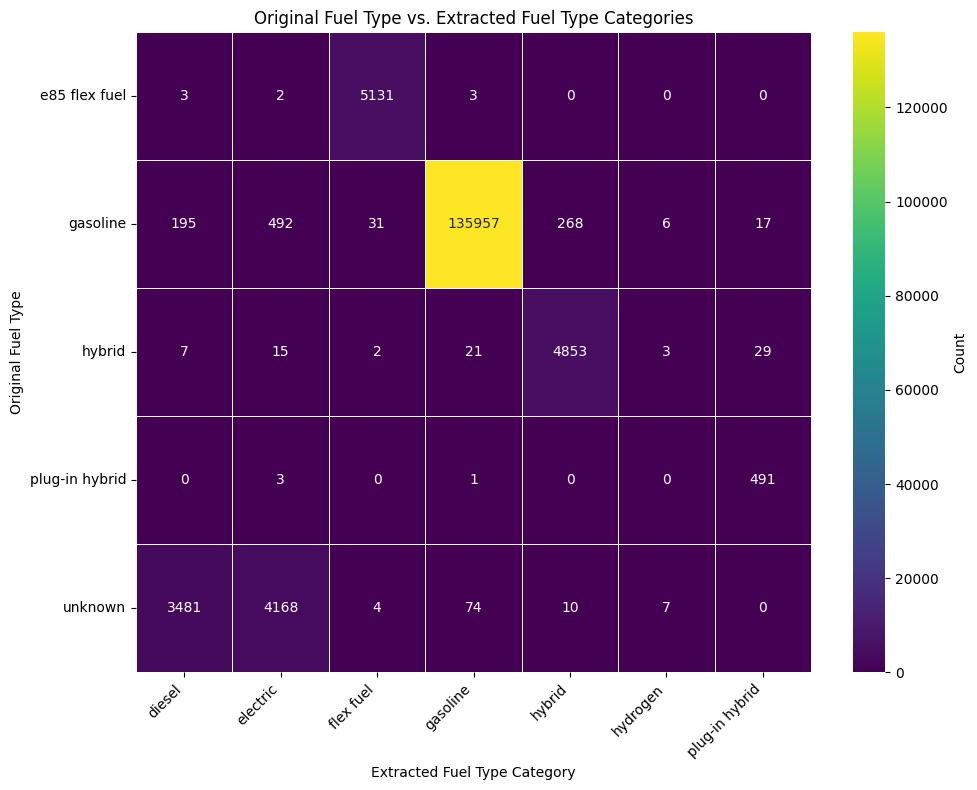

In [402]:
# Concatenate extracted features back to subset_hp
subset_hp_with_features = pd.concat([subset_hp, extracted_features_hp], axis=1)

# Compare extracted fuel type and fuel_type column
comparison_df = pd.concat([
    subset_hp['engine_clean'],
    subset_hp['fuel_type'],                              # Original fuel_type
    extracted_features_hp['engine_fuel_type_categorized'] # Extracted fuel type
], axis=1).dropna(subset=['engine_clean']) # dropna for 'engine_clean' just to focus on processed rows

# Create cross-tabulation
crosstb = pd.crosstab(comparison_df['fuel_type'], comparison_df['engine_fuel_type_categorized'], dropna=False)

# Visualize crosstb
plt.figure(figsize=(10, 8))
sns.heatmap(crosstb, annot=True, fmt='d', cmap='viridis', linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Original Fuel Type vs. Extracted Fuel Type Categories')
plt.xlabel('Extracted Fuel Type Category')
plt.ylabel('Original Fuel Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

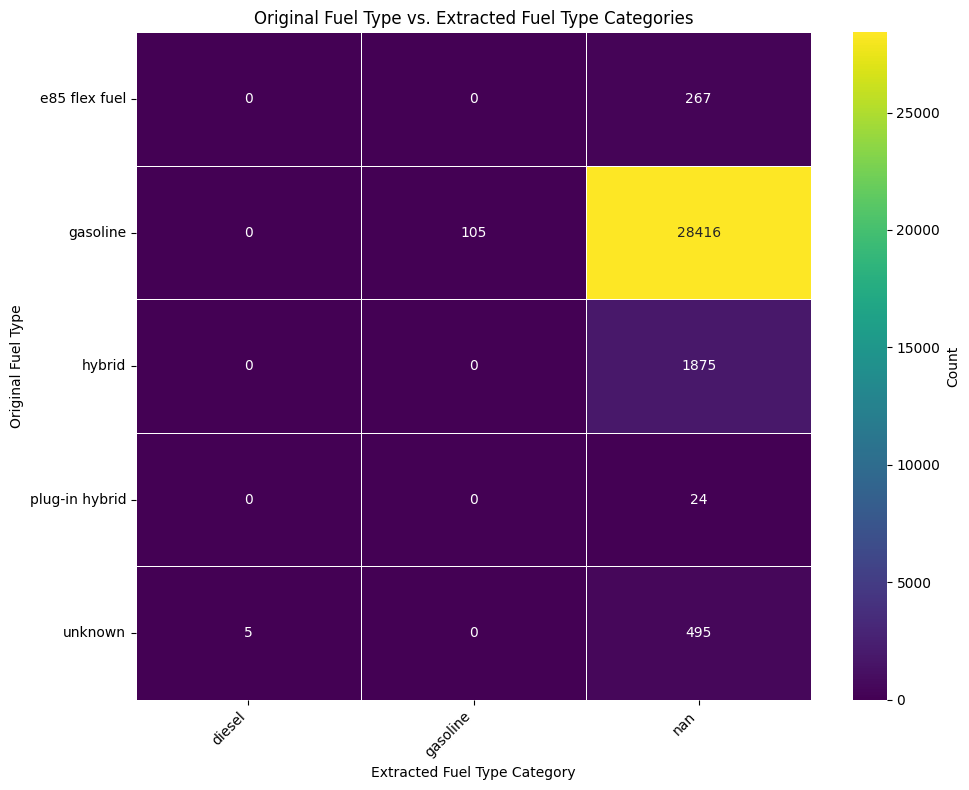

In [403]:
# Concatenate extracted features back to subset_l
subset_l_with_features = pd.concat([subset_l, extracted_features_l], axis=1)

# Compare extracted fuel type and fuel_type column
comparison_df = pd.concat([
    subset_l['engine_clean'],
    subset_l['fuel_type'],                              # Original fuel_type
    extracted_features_l['engine_fuel_type_categorized'] # Extracted fuel type
], axis=1).dropna(subset=['engine_clean']) # dropna for 'engine_clean' just to focus on processed rows

# Create cross-tabulation
crosstb = pd.crosstab(comparison_df['fuel_type'], comparison_df['engine_fuel_type_categorized'], dropna=False)

# Visualize crosstb
plt.figure(figsize=(10, 8))
sns.heatmap(crosstb, annot=True, fmt='d', cmap='viridis', linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Original Fuel Type vs. Extracted Fuel Type Categories')
plt.xlabel('Extracted Fuel Type Category')
plt.ylabel('Original Fuel Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [404]:
def preprocess_engine_features(df, numerical_imputation_values=None):

    # Apply extract_engine_features to df
    extracted_features = df['engine_clean'].apply(extract_engine_features)

    # Concatenate the new features back to main DataFrame
    for col in extracted_features.columns:
        df[col] = extracted_features[col]

    # Define a mapping for original fuel types
    fuel_type_standardization_map = {
        'gasoline': 'gasoline',
        'diesel': 'diesel',
        'hybrid': 'hybrid',
        'e85 flex fuel': 'flex fuel',
        'electric': 'electric',
        'hydrogen': 'hydrogen',
        'natural gas': 'cng/lpg',
        'cng': 'cng/lpg',
        'lpg': 'cng/lpg',
        'plug-in hybrid': 'plug-in hybrid',
        'unknown': np.nan # Map 'unknown' in original to NaN so it can be filled
    }

    # Create a new 'final_fuel_type' column, using values from original 'fuel_type'
    df['final_fuel_type'] = df['fuel_type']

    # Map original fuel types to a standardized set
    df['final_fuel_type'] = df['final_fuel_type'].map(fuel_type_standardization_map)

    # Fill NaNs using extracted fuel type
    df['final_fuel_type'] = df['final_fuel_type'].fillna(df['engine_fuel_type_categorized'].squeeze())

    # Fill all missing values with unknown
    df['final_fuel_type'] = df['final_fuel_type'].fillna('unknown')
    df['engine_layout'] = df['engine_layout'].fillna('unknown')
    df['engine_injection_type'] = df['engine_injection_type'].fillna('unknown')
    df['engine_valvetrain'] = df['engine_valvetrain'].fillna('unknown')
    df['engine_aspiration'] = df['engine_aspiration'].fillna('unknown')

    return df

In [405]:
# Apply to both train_df and test_df
train_df_cleaned = preprocess_engine_features(train_df.copy())
test_df_cleaned = preprocess_engine_features(test_df.copy())

In [406]:
# Verify the columns
print(train_df_cleaned.columns)
print(test_df_cleaned.columns)

Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'price', 'car_age',
       'mileage_per_year', 'brand_grp', 'model_base', 'mdl_grp',
       'engine_clean', 'engine_hp', 'engine_size', 'engine_cyl',
       'engine_layout', 'engine_fuel_type_raw', 'engine_fuel_type_categorized',
       'engine_valves', 'engine_injection_type', 'engine_valvetrain',
       'engine_aspiration', 'final_fuel_type'],
      dtype='object')
Index(['brand', 'model', 'milage', 'fuel_type', 'engine', 'transmission',
       'ext_col', 'int_col', 'accident', 'clean_title', 'car_age',
       'mileage_per_year', 'brand_grp', 'model_base', 'mdl_grp',
       'engine_clean', 'engine_hp', 'engine_size', 'engine_cyl',
       'engine_layout', 'engine_fuel_type_raw', 'engine_fuel_type_categorized',
       'engine_valves', 'engine_injection_type', 'engine_valvetrain',
       'engine_aspiration', 'final_fuel_type'],
      dtype='object')


#### Filter and group 'transmission'

**Strategy for `transmission`**

* The original `transmission` column had inconsistent and noisy labels like `'m/t'`, `'a/t'`, `'manual'`, `'automatic'`, `'cvt'`, etc.

* I simplified this by mapping them into three clean categories: `'manual'`, `'automatic'`, and `'cvt'`.

* Anything that didn’t match those patterns was grouped as `'other'`.

* I will apply `OneHotEncoding` to these at later steps.

* I applied this transformation to both train and test sets.

In [407]:
print("Top values (transmission):")
print(train_df['transmission'].value_counts().head(30))

print("\nRare or weird values (transmission):")
print(train_df['transmission'].value_counts().tail(10))

Top values (transmission):
transmission
a/t                                  49904
8-speed a/t                          20652
transmission w/dual shift mode       19255
6-speed a/t                          18044
6-speed m/t                          11998
7-speed a/t                          11124
automatic                            10691
8-speed automatic                     8430
10-speed a/t                          8044
9-speed a/t                           3866
5-speed a/t                           3217
10-speed automatic                    3164
6-speed automatic                     2799
4-speed a/t                           2546
5-speed m/t                           2409
9-speed automatic                     2325
cvt transmission                      1990
1-speed a/t                           1869
m/t                                   1179
7-speed automatic with auto-shift     1172
automatic cvt                          829
8-speed automatic with auto-shift      549
1-speed automa

In [408]:
# Define function to group transmission
def simplify_transmission(val):
    val = val.lower()
    if 'manual' in val or 'm/t' in val:
        return 'manual'
    elif 'a/t' in val or 'automatic' in val or 'at' in val or 'dual shift' in val or 'overdrive' in val:
        return 'auto'
    elif 'cvt' in val:
        return 'cvt'
    else:
        return 'other'

# Apply function on both dataset
train_df_cleaned['trn_grp'] = train_df['transmission'].apply(simplify_transmission)
test_df_cleaned['trn_grp'] = test_df['transmission'].apply(simplify_transmission)

In [409]:
# Verify the new cols
print(train_df_cleaned['trn_grp'].value_counts())
print("------------------")
print(test_df_cleaned['trn_grp'].value_counts())

trn_grp
auto      169745
manual     16358
cvt         2005
other        424
Name: count, dtype: int64
------------------
trn_grp
auto      113267
manual     10785
cvt         1349
other        289
Name: count, dtype: int64


#### Filter and group 'ext_col'

**Strategy for `ext_col`**

* The original color values were inconsistent and messy, with variations like `"blue caelum"` vs `"gt silver"` vs `"thunder gray"`.

* I had already cleaned and lowercased all string columns earlier using function `clean_categorical_columns` at step 1.1.

* I combined train and test color values to get the full distribution and identified the most common base colors like `'black'`, `'white'`, `'gray'`, `'silver'`, `'blue'`, etc.

* Then I created a function to map each color string to one of those base colors using keyword matching.

* If no base color was found in the string, I grouped it as `'other'`.

In [410]:
print("Top values (ext_col):")
print(train_df['ext_col'].value_counts().head(20))

print("\nRare or weird values (ext_col):")
print(train_df['ext_col'].value_counts().tail(10))

Top values (ext_col):
ext_col
black                      48687
white                      43815
gray                       25293
silver                     16995
blue                       14558
red                         9901
green                       2698
gold                        1668
brown                       1162
orange                      1139
beige                       1087
yellow                       978
bright white clearcoat       755
diamond black                710
agate black metallic         639
summit white                 514
silver ice metallic          456
mythos black metallic        417
midnight black metallic      379
–                            366
Name: count, dtype: int64

Rare or weird values (ext_col):
ext_col
aventurine green metallic             7
thunder gray                          7
silky silver                          7
nautical blue pearl                   7
frozen white                          6
dark gray metallic                    6
gra

In [411]:
# Combine train and test color values
combined_colors = pd.concat([train_df['ext_col'], test_df['ext_col']], axis=0)

# Extract most frequent base color keywords
top_colors = combined_colors.value_counts().head(20).index.tolist()

# Flatten to base color groups from common names
ext_base_colors = []
for val in top_colors:
    for token in val.split():
        if token not in ext_base_colors:
            ext_base_colors.append(token)
    if len(ext_base_colors) >= 20:
        break

print("Auto-detected base colors:", ext_base_colors)

Auto-detected base colors: ['black', 'white', 'gray', 'silver', 'blue', 'red', 'green', 'gold', 'brown', 'orange', 'beige', 'yellow', 'bright', 'clearcoat', 'diamond', 'agate', 'metallic', 'summit', 'ice', 'mythos']


In [412]:
# Define base colors based on results above
ext_base_colors = [
    'black', 'white', 'gray', 'silver', 'blue', 'red', 'green',
    'gold', 'brown', 'orange'
]

# Create function to match into color groups
def match_col_group(val, base_colors):
    val = str(val).strip().lower()

    for base in base_colors:
        if base in val:
            return base

    return 'other'

In [413]:
# Apply function on both train_df and test_df
train_df_cleaned['ext_col_grp'] = train_df['ext_col'].apply(lambda x: match_col_group(x, ext_base_colors))
test_df_cleaned['ext_col_grp'] = test_df['ext_col'].apply(lambda x: match_col_group(x, ext_base_colors))

In [415]:
# Verify the new cols
print(train_df_cleaned['ext_col_grp'].value_counts())
print("------------------")
print(test_df_cleaned['ext_col_grp'].value_counts())

ext_col_grp
black     53916
white     47945
gray      26669
silver    18809
blue      15837
red       11795
other      6612
green      2948
gold       1668
brown      1185
orange     1148
Name: count, dtype: int64
------------------
ext_col_grp
black     35821
white     31963
gray      17844
silver    12505
blue      10559
red        7900
other      4357
green      2041
gold       1170
orange      765
brown       765
Name: count, dtype: int64


#### Filter and group 'int_col'

**Strategy for Grouping `int_col`**

* I followed the same approach as what I did to `ext_col`.

* I combined both train and test `int_col` values to get the full distribution.

* Then, I took the top 10 most frequent values, split them into tokens, and used those to build the base color list.

* After that, I replaced bad data like `'-'` with `'unknown'`, and redefined the base color list, and apply matching. If no match was found, I labeled it as `'other'`.

* These transformation are applied to both train and test sets.

In [416]:
print("Top values (int_col):")
print(train_df['int_col'].value_counts().head(20))

print("\nRare or weird values (int_col):")
print(train_df['int_col'].value_counts().tail(10))

Top values (int_col):
int_col
black                  107706
beige                   24503
gray                    21204
brown                    5810
red                      5145
white                    4749
–                        4527
jet black                2398
ebony                    1833
orange                    936
blue                      743
global black              628
silver                    429
nero ade                  389
gold                      367
black / express red       326
black onyx                256
graphite                  254
rioja red                 244
diesel gray / black       223
Name: count, dtype: int64

Rare or weird values (int_col):
int_col
beluga                  10
sport                   10
very light cashmere     10
mistral gray / raven     9
carbon black             8
light gray               8
bianco polar             7
nougat brown             7
classic red              7
cobalt blue              6
Name: count, dtype: int64


In [417]:
# Combine train and test color values
combined_colors = pd.concat([train_df['int_col'], test_df['int_col']], axis=0)

# Extract most frequent base color keywords
top_colors = combined_colors.value_counts().head(20).index.tolist()

# Flatten to base color groups from common names
int_base_colors = []
for val in top_colors:
    for token in val.split():
        if token not in int_base_colors:
            int_base_colors.append(token)
    if len(int_base_colors) >= 20:
        break

print("Auto-detected base colors:", int_base_colors)

Auto-detected base colors: ['black', 'beige', 'gray', 'brown', 'red', 'white', '–', 'jet', 'ebony', 'orange', 'blue', 'global', 'silver', 'nero', 'ade', 'gold', '/', 'express', 'graphite', 'rioja']


In [418]:
# Re-define the base int_col
int_base_colors = [
    'black', 'beige', 'gray', 'brown', 'red', 'white',
    'orange', 'blue', 'silver', 'gold'
]

# Apply function on both train_df and test_df
train_df_cleaned['int_col_grp'] = train_df['int_col'].apply(lambda x: match_col_group(x, int_base_colors))
test_df_cleaned['int_col_grp'] = test_df['int_col'].apply(lambda x: match_col_group(x, int_base_colors))

In [419]:
# Verify the new cols
print(train_df_cleaned['int_col_grp'].value_counts())
print("------------------")
print(test_df_cleaned['int_col_grp'].value_counts())

int_col_grp
black     112676
beige      24917
gray       21500
other      10523
brown       6017
red         5507
white       4794
orange       969
blue         833
silver       429
gold         367
Name: count, dtype: int64
------------------
int_col_grp
black     75036
beige     16768
gray      14403
other      6845
brown      4061
red        3724
white      3157
orange      649
blue        541
silver      306
gold        200
Name: count, dtype: int64


In [428]:
print(train_df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188532 entries, 0 to 188531
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   brand                         188532 non-null  object 
 1   model                         188532 non-null  object 
 2   milage                        188532 non-null  int64  
 3   fuel_type                     188532 non-null  object 
 4   engine                        188532 non-null  object 
 5   transmission                  188532 non-null  object 
 6   ext_col                       188532 non-null  object 
 7   int_col                       188532 non-null  object 
 8   accident                      188532 non-null  object 
 9   clean_title                   188532 non-null  object 
 10  price                         188532 non-null  int64  
 11  car_age                       188532 non-null  int64  
 12  mileage_per_year              188532 non-nul

In [429]:
print(test_df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   brand                         125690 non-null  object 
 1   model                         125690 non-null  object 
 2   milage                        125690 non-null  int64  
 3   fuel_type                     125690 non-null  object 
 4   engine                        125690 non-null  object 
 5   transmission                  125690 non-null  object 
 6   ext_col                       125690 non-null  object 
 7   int_col                       125690 non-null  object 
 8   accident                      125690 non-null  object 
 9   clean_title                   125690 non-null  object 
 10  car_age                       125690 non-null  int64  
 11  mileage_per_year              125690 non-null  float64
 12  brand_grp                     125690 non-nul

In [427]:
train_df_cleaned.to_csv("train_df_cleaned.csv", index=False)
test_df_cleaned.to_csv("test_df_cleaned.csv", index=False)

#### Split X_train, y_train, X_test

**Notes:**

* Since there is no `price` column in `test_df`, I’m not using it for evaluation.

* Instead, I’m splitting the original `train_df` into a training and test set using `train_test_split`.

* This lets me evaluate model performance properly using `y_test`, which contains the actual target values.

In [430]:
# Load cleaned train and test sets
train_df_cleaned = pd.read_csv("train_df_cleaned.csv")
test_df_cleaned = pd.read_csv("test_df_cleaned.csv")

In [431]:
# Define target
target = 'price'

# Separate target and features
y = train_df_cleaned[target]
X = train_df_cleaned.drop(columns=[target])

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [432]:
print(X_train.shape)
print(X_test.shape)

(150825, 30)
(37707, 30)


In [433]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 150825 entries, 184030 to 121958
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   brand                         150825 non-null  object 
 1   model                         150825 non-null  object 
 2   milage                        150825 non-null  int64  
 3   fuel_type                     150825 non-null  object 
 4   engine                        150825 non-null  object 
 5   transmission                  150825 non-null  object 
 6   ext_col                       150825 non-null  object 
 7   int_col                       150825 non-null  object 
 8   accident                      150825 non-null  object 
 9   clean_title                   150825 non-null  object 
 10  car_age                       150825 non-null  int64  
 11  mileage_per_year              150825 non-null  float64
 12  brand_grp                     150825 non-nul

In [434]:
print(X_train.isna().sum())

brand                                0
model                                0
milage                               0
fuel_type                            0
engine                               0
transmission                         0
ext_col                              0
int_col                              0
accident                             0
clean_title                          0
car_age                              0
mileage_per_year                     0
brand_grp                            0
model_base                           0
mdl_grp                              0
engine_clean                         0
engine_hp                        26611
engine_size                       5354
engine_cyl                       11305
engine_layout                        0
engine_fuel_type_raw             26303
engine_fuel_type_categorized     26303
engine_valves                   132027
engine_injection_type                0
engine_valvetrain                    0
engine_aspiration        

**Strategy for handling mising values from new engine features:**

* I found missing values in `engine_hp`, `engine_size`, and `engine_cyl`, which came from parsing unstructured text in the `engine` column.

* For `engine_cyl`, I am going to fill missing values with `-1` since I’ll be applying one-hot encoding later. This way, unknowns can be treated as a separate category.

* `engine_hp` and `engine_size` will be kept as-is for now, without filling the `NaN` records since I am going to impute them later on.


#### Apply one-hot encoding for categorical cols

In [435]:
# Get list of cat cols
cat_cols_train = X_train.select_dtypes(include='object').columns.tolist()
cat_cols_train

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'brand_grp',
 'model_base',
 'mdl_grp',
 'engine_clean',
 'engine_layout',
 'engine_fuel_type_raw',
 'engine_fuel_type_categorized',
 'engine_injection_type',
 'engine_valvetrain',
 'engine_aspiration',
 'final_fuel_type',
 'trn_grp',
 'ext_col_grp',
 'int_col_grp']

In [436]:
unique_counts = X_train[cat_cols_train].nunique(dropna=False).sort_values(ascending=False)
print(unique_counts)

model                           1891
model_base                      1326
engine                          1116
engine_clean                    1113
ext_col                          317
int_col                          152
mdl_grp                          101
brand                             57
transmission                      51
brand_grp                         29
engine_layout                     11
int_col_grp                       11
ext_col_grp                       11
engine_fuel_type_raw               9
engine_fuel_type_categorized       8
final_fuel_type                    8
fuel_type                          5
engine_injection_type              5
engine_valvetrain                  4
engine_aspiration                  4
trn_grp                            4
accident                           3
clean_title                        2
dtype: int64


In [437]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define columns to drop
cols_to_drop_before_ohe = [
    'brand', # Already grouped
    'model', # Raw high-cardinality col
    'model_base', # Already grouped
    'fuel_type', # Already transformed to final_fuel_type
    'transmission', # Already grouped
    'ext_col', # Already grouped
    'int_col', # Already grouped
    'engine', # Original raw engine string
    'engine_clean', # Cleaned engine string (features extracted from it)
    'engine_fuel_type_raw', # Raw types that are categorized later
    'engine_fuel_type_categorized' # Already transformed to final_fuel_type
]

# Identify remaining categorical columns
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns
cat_cols_for_ohe = [col for col in cat_cols if col not in cols_to_drop_before_ohe]

def encode_ohe(train_df, test_df, cat_cols, drop_cols):
    """
    One-hot encodes categorical features in train_df and test_df.

    Parameters:
    - train_df (DataFrame): Training features
    - test_df (DataFrame): Test features (no target)
    - cat_cols (list): All candidate categorical columns
    - drop_cols (list): Categorical columns to exclude from encoding

    Returns:
    - train_encoded_df (DataFrame): OHE result on train_df
    - test_encoded_df (DataFrame): OHE result on test_df
    - ohe (OneHotEncoder): Fitted encoder
    - ohe_feature_names
    """

    # Prepare drop list for unknown/other categories
    drop_categories = []
    for col in cat_cols_for_ohe:
        categories = train_df[col].unique()
        drops = []
        if 'unknown' in categories:
            drops.append('unknown')
        if 'other' in categories:
            drops.append('other')
        drop_categories.append(drops if drops else None)

    # Initialize encoder
    ohe = OneHotEncoder(
        drop=drop_categories,
        handle_unknown='ignore',
        sparse_output=False
    )

    # Fit and transform on train
    X_train_encoded = ohe.fit_transform(train_df[cat_cols_for_ohe])

    # Transform on test
    X_test_encoded = ohe.transform(test_df[cat_cols_for_ohe])

    # Get feature names
    ohe_feature_names = ohe.get_feature_names_out(cat_cols_for_ohe)

    return X_train_encoded, X_test_encoded, ohe, ohe_feature_names

In [438]:
# Apply one-hot encoding
X_train_encoded, X_test_encoded, ohe, ohe_feature_names = encode_ohe(
    train_df=X_train,
    test_df=X_test,
    cat_cols=cat_cols,
    drop_cols=cols_to_drop_before_ohe
)

In [440]:
ohe_feature_names

array(['accident_none', 'accident_reported', 'clean_title_yes',
       'brand_grp_acura', 'brand_grp_audi', 'brand_grp_bentley',
       'brand_grp_bmw', 'brand_grp_cadillac', 'brand_grp_chevrolet',
       'brand_grp_dodge', 'brand_grp_ford', 'brand_grp_gmc',
       'brand_grp_honda', 'brand_grp_hyundai', 'brand_grp_infiniti',
       'brand_grp_jaguar', 'brand_grp_jeep', 'brand_grp_kia',
       'brand_grp_land', 'brand_grp_lexus', 'brand_grp_lincoln',
       'brand_grp_mazda', 'brand_grp_mercedes-benz', 'brand_grp_mini',
       'brand_grp_nissan', 'brand_grp_porsche', 'brand_grp_ram',
       'brand_grp_subaru', 'brand_grp_tesla', 'brand_grp_toyota',
       'brand_grp_volkswagen', 'mdl_grp_1500 big', 'mdl_grp_1500 laramie',
       'mdl_grp_328 i', 'mdl_grp_330 i', 'mdl_grp_335 i', 'mdl_grp_435 i',
       'mdl_grp_750 i', 'mdl_grp_911 carrera', 'mdl_grp_911 gt3',
       'mdl_grp_911 turbo', 'mdl_grp_a3 2.0t', 'mdl_grp_a4 2.0t',
       'mdl_grp_a5 2.0t', 'mdl_grp_a8 l', 'mdl_grp_amg c',
  

In [441]:
# Verify the shapes
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(150825, 131)
(37707, 131)


### 1.5 Normalize or scale the features

**Approach for scaling numeric features**

* I selected all numeric columns from the dataset to explore their distributions.

* Used `.describe()` to check ranges and standard deviations, then plotted histograms to visually inspect how skewed or spread out each feature is.

* This helps me decide later which columns actually need scaling or transformation.

In [442]:
# Select numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Use describe to check features by highest std
X_train[numeric_cols].describe().T.sort_values(by='std', ascending=False)

,count,mean,std,min,25%,50%,75%,max
milage,150825.0,65763.480225,49852.176772,100.00,24158.000000,57800.000000,95426.000000,405000.0
mileage_per_year,150825.0,7221.996581,4605.472710,5.00,4285.714286,6857.142857,9444.444444,117500.0
engine_hp,124214.0,343.277996,114.846903,70.00,263.000000,329.000000,416.000000,1020.0
engine_valves,18798.0,22.501968,7.472471,12.00,16.000000,24.000000,24.000000,97.0
car_age,150825.0,9.178538,5.662096,1.00,5.000000,8.000000,12.000000,51.0
engine_cyl,139520.0,6.302028,1.602925,1.00,6.000000,6.000000,8.000000,12.0
engine_size,145471.0,3.776577,1.352851,0.65,3.000000,3.500000,4.700000,8.4


#### Plot distributions on numerical columns

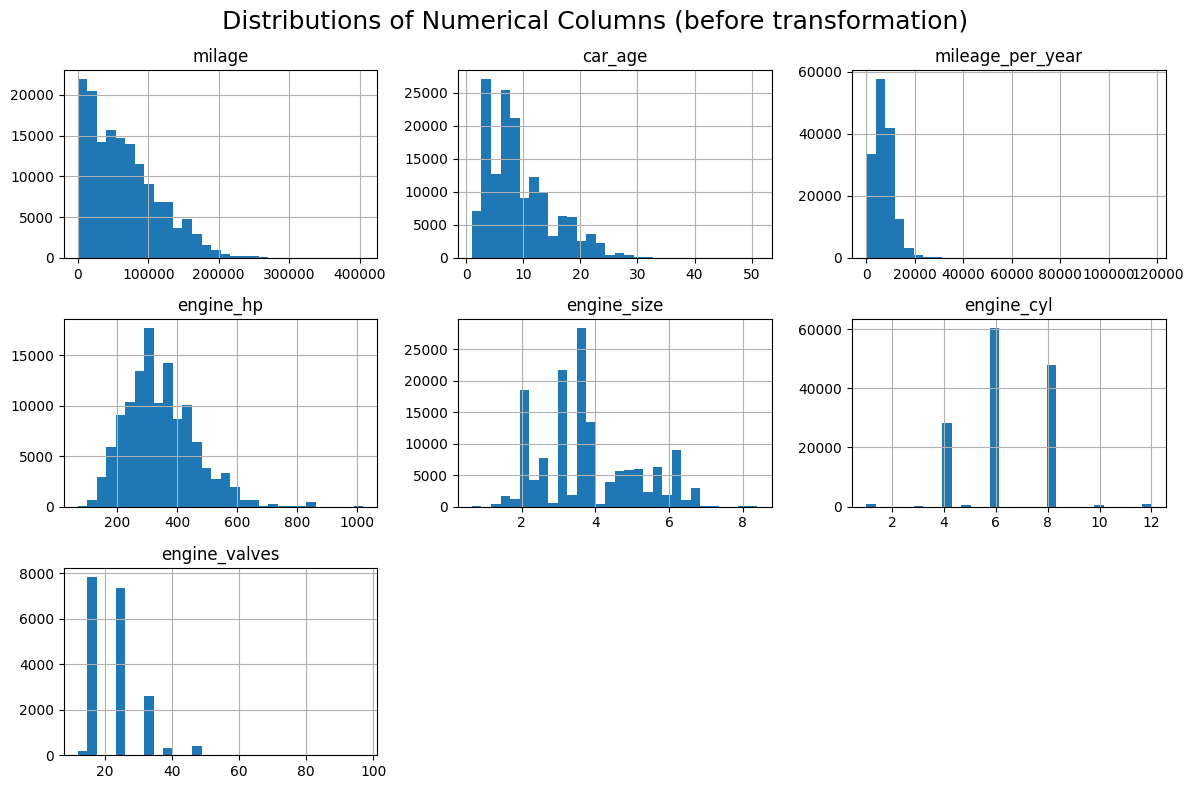

In [443]:
# Plot distributions of numeric features
X_train[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distributions of Numerical Columns (before transformation)", fontsize=18)
plt.tight_layout()
plt.show()

**Observations from distributions and summary stats:**

* `milage` is highly right-skewed. Most values are under 100,000 (75th percentile: 95,000), but a few extreme outliers go up to 400,000. As shown in the `describe()` output, the mean (67,505) is much higher than the median (57,785), confirming skew.

* `car_age` is also right-skewed, peaking around 5–10 years (75th percentile: 12), but some cars go up to 51 years.

* `engine_hp` looks almost bell-shaped but slightly skewed right. Mean is 343, median is 329, and outliers go beyond 1000.

* `engine_size` is multi-modal, with peaks at common engine sizes like 2.0L, 3.0L, 4.0L.

#### Detect outliers

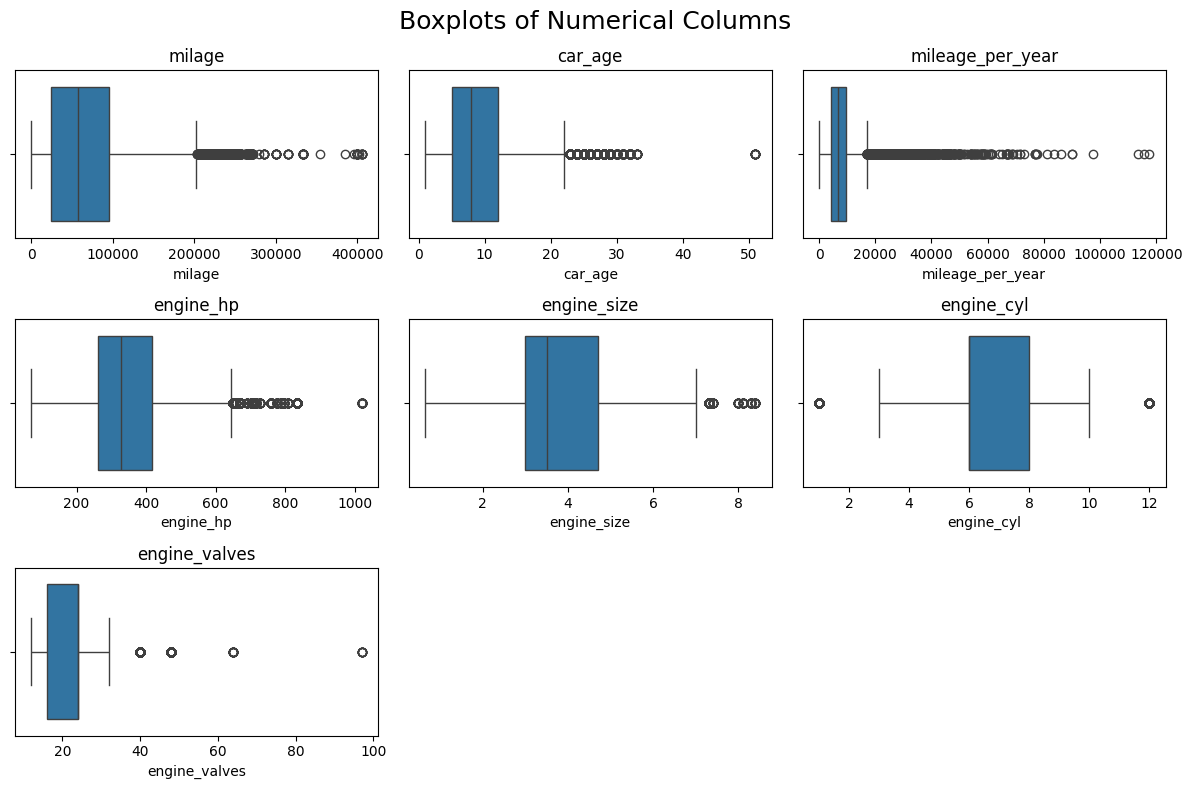

In [444]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=X_train[col], ax=axes[i])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False) # set visible to false to hide extra plots

plt.suptitle("Boxplots of Numerical Columns", fontsize=18)
plt.tight_layout()
plt.show()

**Observations from outlier check:**

* `milage` has extreme outliers on the high end. Most cars fall below \~100,000 KM, but some go beyond 300K+. I’ll apply `log1p()` to reduce right skew and compress the extreme values.

* `car_age` shows a clean spread between 0 and 20, but a few cars go up to 50 years, which is rare. I’ll keep them and apply `StandardScaler` to normalize the scale.

* `engine_hp` has some visible high-end outliers beyond 600 HP. I’ll use `RobustScaler` to reduce the influence of those extremes.

* `engine_size` doesn’t have sharp outliers but shows a few cars >7L, which are uncommon. I’ll apply `StandardScaler` to keep scaling consistent across numeric features.


#### Impute and Scale numerical cols

In [445]:
# Get list of numerical cols
num_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols_train

['milage',
 'car_age',
 'mileage_per_year',
 'engine_hp',
 'engine_size',
 'engine_cyl',
 'engine_valves']

In [446]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define numerical columns explicitly
numerical_cols = ['milage',
    'car_age',
    'mileage_per_year',
    'engine_hp',
    'engine_size',
    'engine_cyl',
    'engine_valves']

# Verify nan counts
print(X_train[numerical_cols].isna().sum())
print(X_test[numerical_cols].isna().sum())

def impute_and_scale_numerical(train_df, test_df, numerical_cols):
    """
    Imputes and scales selected numerical features using median and standard scaling.
    Returns numpy arrays of scaled values for train and test sets.
    """
    # Imputer and scaler
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    # Fit on train, transform both
    X_train_imputed = imputer.fit_transform(train_df[numerical_cols])
    X_test_imputed = imputer.transform(test_df[numerical_cols])

    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    return X_train_scaled, X_test_scaled, imputer, scaler

milage                   0
car_age                  0
mileage_per_year         0
engine_hp            26611
engine_size           5354
engine_cyl           11305
engine_valves       132027
dtype: int64
milage                  0
car_age                 0
mileage_per_year        0
engine_hp            6647
engine_size          1344
engine_cyl           2921
engine_valves       33088
dtype: int64


In [447]:
# Apply imputation and scaling
X_train_scaled, X_test_scaled, num_imputer, num_scaler = impute_and_scale_numerical(
    train_df=X_train,
    test_df=X_test,
    numerical_cols=numerical_cols
    )

In [448]:
# Verify the nan values
print("Train NaNs:", np.isnan(X_train_scaled).sum())
print("Test NaNs:", np.isnan(X_test_scaled).sum())

Train NaNs: 0
Test NaNs: 0


In [449]:
# Verify the shapes
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(150825, 7)
(37707, 7)


In [450]:
def combine_encoded_and_scaled_features(X_train_encoded, X_test_encoded,
                                        X_train_scaled, X_test_scaled,
                                        ohe, numerical_cols):
    """
    Horizontally stacks encoded categorical features with scaled numerical features.

    Returns:
        X_train_final (np.ndarray): Combined features for training set
        X_test_final (np.ndarray): Combined features for test set
        feature_names (list): Combined feature names
    """
    # Stack features
    X_train_final = np.hstack([X_train_encoded, X_train_scaled])
    X_test_final = np.hstack([X_test_encoded, X_test_scaled])

    # Get feature names
    cat_feature_names = ohe.get_feature_names_out()
    feature_names = list(cat_feature_names) + numerical_cols

    return X_train_final, X_test_final, feature_names

#### Combine encoded and scaled features

In [451]:
# Combine encoded and scaled features
X_train_final, X_test_final, final_feature_names = combine_encoded_and_scaled_features(
    X_train_encoded, X_test_encoded,
    X_train_scaled, X_test_scaled,
    ohe, numerical_cols
)

In [452]:
# Wrap numpy array as dataframe
X_train_final_df = pd.DataFrame(X_train_final, columns=final_feature_names)
X_test_final_df = pd.DataFrame(X_test_final, columns=final_feature_names)

# Verify the final dataframe
print(X_train_final_df.columns)

Index(['accident_none', 'accident_reported', 'clean_title_yes',
       'brand_grp_acura', 'brand_grp_audi', 'brand_grp_bentley',
       'brand_grp_bmw', 'brand_grp_cadillac', 'brand_grp_chevrolet',
       'brand_grp_dodge',
       ...
       'mdl_grp_wrangler sport', 'mdl_grp_wrangler unlimited',
       'mdl_grp_yukon xl', 'milage', 'car_age', 'mileage_per_year',
       'engine_hp', 'engine_size', 'engine_cyl', 'engine_valves'],
      dtype='object', length=138)


In [453]:
# Check rows
X_train_final_df.head()

,accident_none,accident_reported,clean_title_yes,brand_grp_acura,brand_grp_audi,brand_grp_bentley,brand_grp_bmw,brand_grp_cadillac,brand_grp_chevrolet,brand_grp_dodge,...,mdl_grp_wrangler sport,mdl_grp_wrangler unlimited,mdl_grp_yukon xl,milage,car_age,mileage_per_year,engine_hp,engine_size,engine_cyl,engine_valves
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.082012,-0.208146,0.105826,-1.272055,-1.328787,-1.476550,0.069563
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.391810,2.264445,0.257758,-0.975023,0.175422,-0.180984,0.069563
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.526288,-0.737987,2.427121,-0.150996,-0.802314,-0.180984,0.069563
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.024362,0.851536,-0.567013,-0.112670,-0.200630,-0.180984,27.267915
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.218877,-1.267828,-1.025305,3.605029,1.830051,1.114582,0.069563


In [454]:
# Check rows
X_test_final_df.head()

,accident_none,accident_reported,clean_title_yes,brand_grp_acura,brand_grp_audi,brand_grp_bentley,brand_grp_bmw,brand_grp_cadillac,brand_grp_chevrolet,brand_grp_dodge,...,mdl_grp_wrangler sport,mdl_grp_wrangler unlimited,mdl_grp_yukon xl,milage,car_age,mileage_per_year,engine_hp,engine_size,engine_cyl,engine_valves
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.266057,-0.208146,-0.143199,0.998807,0.476263,1.114582,0.069563
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.004744,-0.208146,0.223214,-0.112670,-0.576683,-0.180984,0.069563
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.880256,-0.561373,2.399835,-0.112670,-0.125420,-0.180984,0.069563
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.757512,-0.031532,-0.892612,1.046716,-0.200630,-0.180984,0.069563
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.787200,-0.914600,-0.128542,-0.888787,-1.328787,-1.476550,0.069563


## 2. Exploratory Data Analysis

### 2.1 Visualize Price Distribution, Correlations, and Key Relationships

In [455]:
print(y_train.shape)
print(y_train.value_counts())

(150825,)
price
15000     1520
12000     1157
30000     1003
29000      994
12500      978
          ... 
101998      17
259991      16
45998       16
52598       16
107998      16
Name: count, Length: 1569, dtype: int64


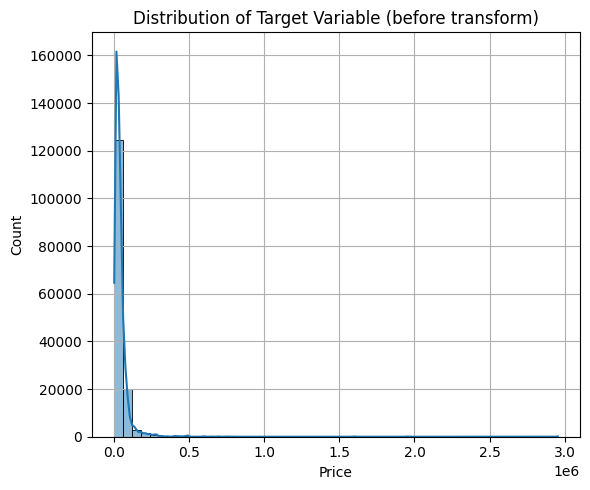

In [456]:
# Plot Distribution before transform
plt.figure(figsize=(6, 5))
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribution of Target Variable (before transform)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation of price distribution:**

* The target variable `price` is highly right-skewed.

* Most values are concentrated under 100k, with a long tail reaching close to 3 million.

* This kind of distribution can throw off regression models due to extreme outliers.

* That's why I will apply `log1p()` transformation to reduce skewness and stabilize variance.

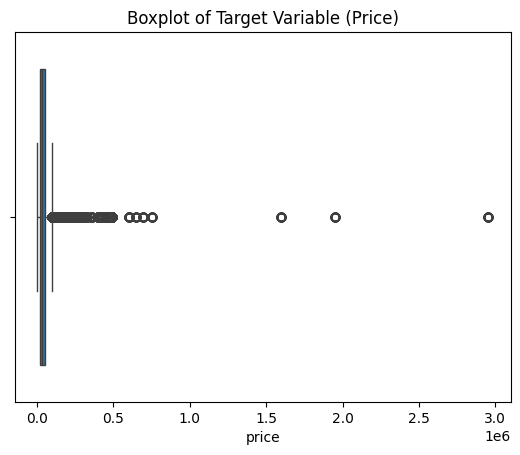

In [457]:
# Plot boxplot to check outliers
sns.boxplot(x=train_df['price'])
plt.title("Boxplot of Target Variable (Price)")
plt.show()

In [458]:
# Check number of price outliers
q1 = train_df['price'].quantile(0.25)
q3 = train_df['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = train_df[train_df['price'] > upper_bound]
print(f"Number of high-end price outliers: {len(outliers)}")

Number of high-end price outliers: 10880


**Observation from outlier detection**

* `price` is heavily right-skewed with a long tail toward high values.

* Boxplot shows several extreme high-end values well beyond the typical range.

* Using IQR method, I found 10,880 high-end outliers above the upper bound.

* These outliers likely include luxury or rare vehicles with unusually high prices.

* I will apply `log1p()` transformation on `price` to reduce skew and minimize the impact of these extremes during modeling.


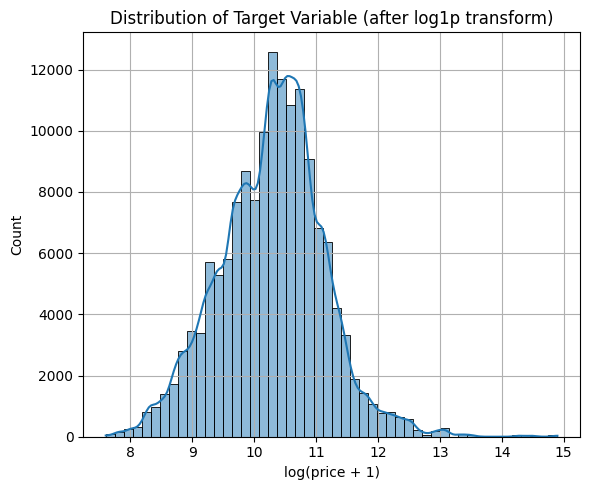

In [459]:
# Apply log1p transformation to target
y_train_scaled = np.log1p(y_train)

# Plot Distribution after tranform
plt.figure(figsize=(6, 5))
sns.histplot(y_train_scaled, bins=50, kde=True)
plt.title("Distribution of Target Variable (after log1p transform)")
plt.xlabel("log(price + 1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation of price distribution after log1p transformation:**

* After applying log1p, the distribution of the target variable looks much more normalized.

* The extreme right skew in raw price is gone, and now most values are clustered closer to the center.

* This should help models like linear regression capture the pattern better.

In [460]:
# Apply log1p transformation to y_test
y_test_scaled = np.log1p(y_test)

In [461]:
# Convert y_train_scaled to series
y_train_scaled_series = pd.Series(y_train_scaled, name="target")

# Concatenate with features
X_train_final_with_target = pd.concat([X_train_final_df.reset_index(drop=True), y_train_scaled_series.reset_index(drop=True)], axis=1)

# Compute correlations
corr_matrix = X_train_final_with_target.corr().abs()

# Get correlation with target
target_corr = corr_matrix['target'].sort_values(ascending=False).drop('target')

In [462]:
# Print top positive and top negative correlations
print(target_corr.head(15))
print("--------------------")
print(target_corr.tail(15))

milage                       0.696742
car_age                      0.665163
engine_hp                    0.479997
accident_reported            0.296064
accident_none                0.281431
mileage_per_year             0.251948
clean_title_yes              0.199236
engine_cyl                   0.158556
engine_size                  0.151088
brand_grp_porsche            0.122878
mdl_grp_corvette stingray    0.107068
mdl_grp_911 carrera          0.097938
brand_grp_toyota             0.095958
brand_grp_bentley            0.086724
mdl_grp_911 turbo            0.081027
Name: target, dtype: float64
--------------------
mdl_grp_gx 460                0.006971
mdl_grp_sierra 1500           0.006538
mdl_grp_silverado 1500        0.006039
brand_grp_chevrolet           0.005765
mdl_grp_suburban lt           0.004550
mdl_grp_rover discovery       0.004432
brand_grp_audi                0.004283
mdl_grp_sl-class sl           0.003657
brand_grp_ford                0.003630
mdl_grp_wrangler unlimited   

In [463]:
# Get top features
top_20_corr_values = target_corr.abs().sort_values(ascending=False).head(20)
top_20_features = top_20_corr_values.index.tolist()

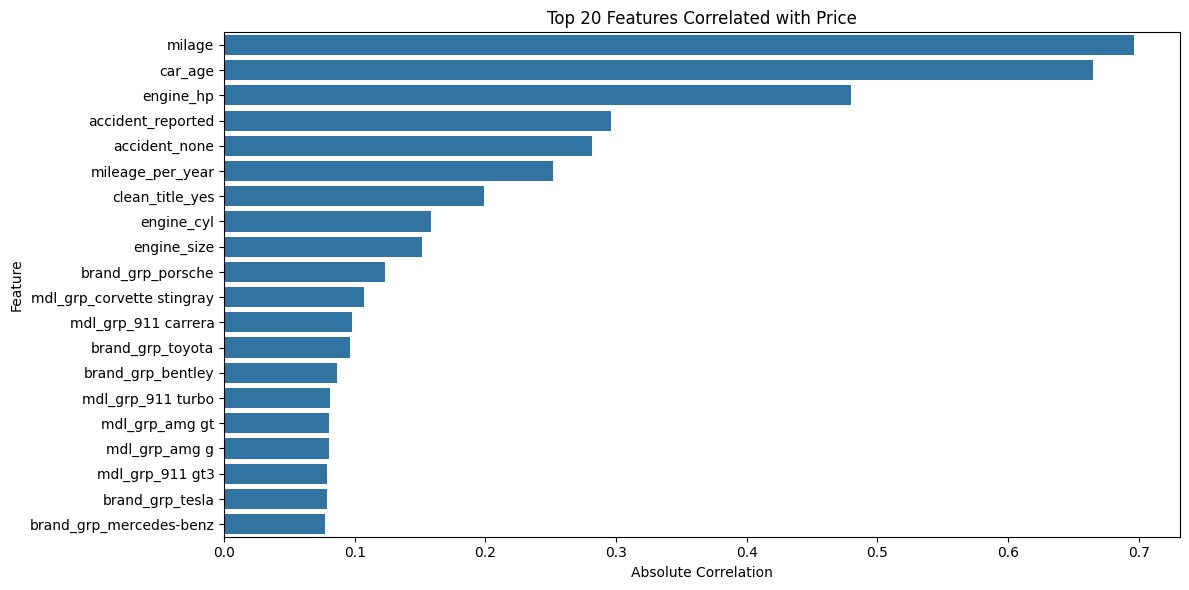

In [464]:
# Plot top 20 features correlated with Price
plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_corr_values,
            y=top_20_features)
plt.title("Top 20 Features Correlated with Price")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Observation from Feature Correlation with Price**

* This chart shows the top 20 features with the highest absolute correlation to `price_log`, regardless of direction.

* Features like `car_age_scaled`, `milage_log`, and `engine_hp_scaled` are most strongly correlated with price.

* These variables are likely important predictors, though I can’t infer if they increase or decrease price just from this chart.

* To understand the direction of impact, I plotted a heatmap in the next step using the correlation matrix.

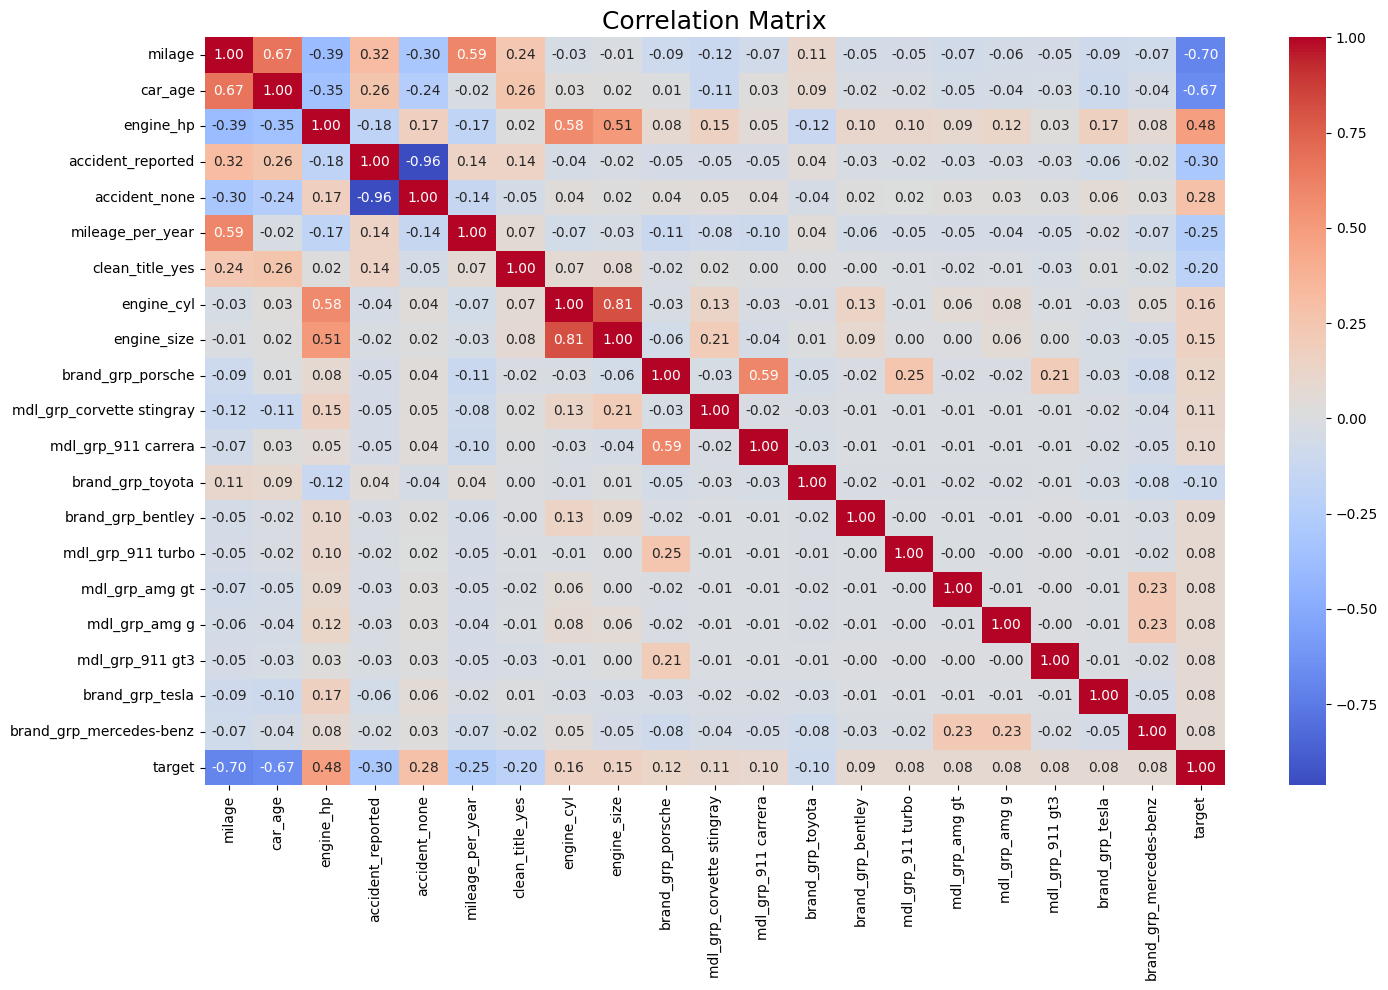

In [465]:
# Create a subset dataframe using top 20 features
top20_corr_df = X_train_final_with_target[top_20_features + ['target']]

# Plot heatmap
plt.figure(figsize=(15,10))
sns.heatmap(top20_corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix", fontsize=18)
plt.tight_layout()
plt.show()

**Observations from correlation matrix**

Based on the updated correlation matrix,

* I can clearly see how some features are strongly associated with the target variable `price_log`:

  * `car_age_scaled` and `milage_log` are **strongly negatively** correlated with `price_log` (–0.68 and –0.63), meaning older or more driven cars tend to be cheaper.

  * `engine_hp_scaled` shows a **strong positive** correlation with `price_log` (0.54), which makes sense since high-performance cars usually cost more.

  * `accident_reported` is negatively correlated (–0.30), while `accident_none` is positively correlated (0.28), showing price differences based on accident history.

* `clean_title_yes` shows a negative correlation of –0.20, indicating that vehicles without clean titles might be priced slightly higher.

* Engine cylinder counts (`engine_cyl_4`: –0.22, `engine_cyl_6`: –0.10) are negatively correlated, suggesting smaller engines are more common in lower-priced models.

* Other features like `fuel_type_hybrid`, `brand_grp_toyota`, or `ext_col_grp_gold` have very low correlations (< 0.10) and may be less useful for prediction.

* There are moderately correlated feature pairs like `car_age_scaled` and `milage_log` (0.58), and `engine_hp_scaled` and `engine_size_scaled` (0.61).

**Strategy**

* Since no feature pair exceeds 0.90, I won’t drop any features at this stage.

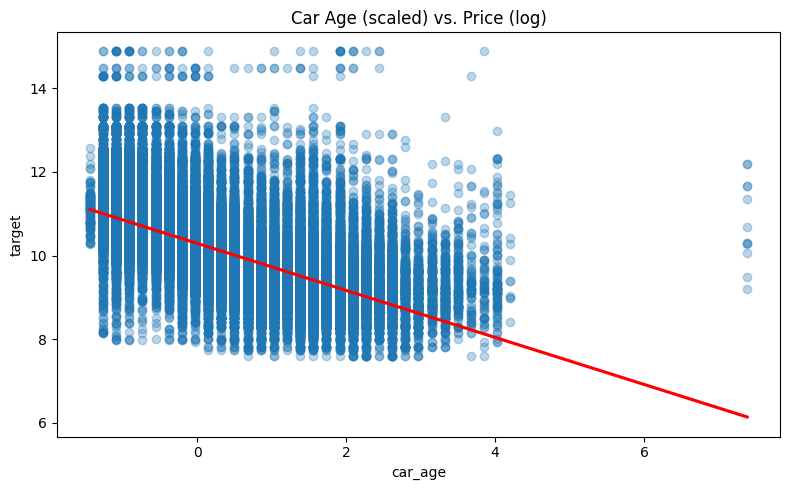

In [466]:
# Check key relationships between car_age_scaled and price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='car_age', y='target', scatter_kws={'alpha': 0.3}, line_kws={"color": "red"})
plt.title("Car Age (scaled) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from Car Age vs. Price**

* Based on the regression plot, there is a clear downward trend where the red line confirms that `price_log` decreases as `car_age_scaled` goes up.

* Newer cars (lower age) generally have higher prices.

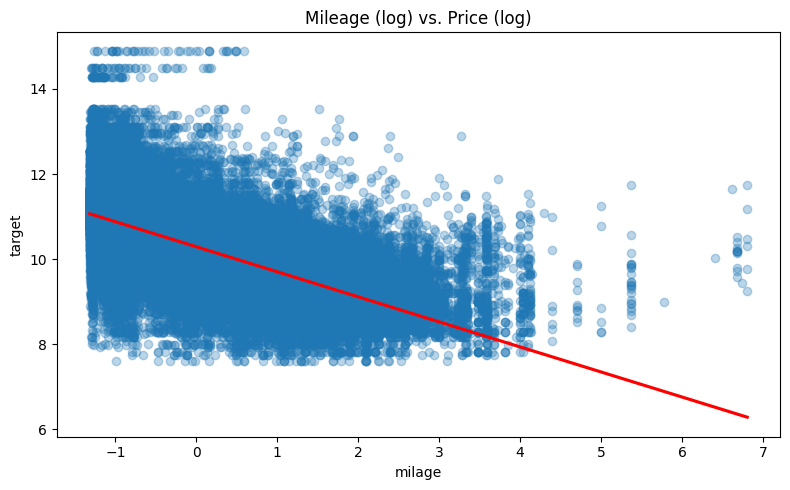

In [467]:
# Check key relationships between milage_log and price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='milage', y='target', scatter_kws={'alpha': 0.3}, line_kws={"color": "red"})
plt.title("Mileage (log) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observations from Mileage vs. Price**

* Based on the regression plot, I can see the trend where `milage_log` increases, `price_log` generally decreases.

* This confirms a clear negative relationship since higher mileage cars are usually cheaper.

### 2.2 Boxplots for Categorical Features vs. `selling_price`

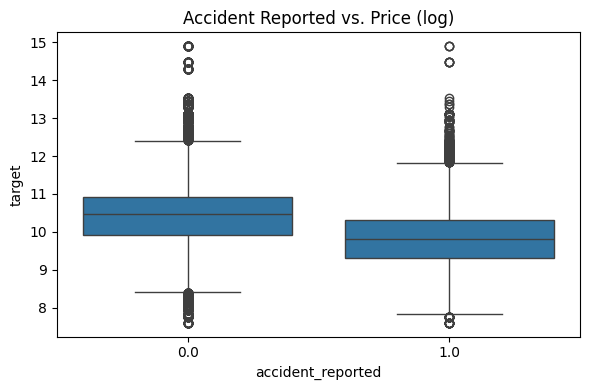

In [468]:
# Plot boxplot to check accident_reported vs price_log
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train_final_with_target, x='accident_reported', y='target')
plt.title("Accident Reported vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from Accident Reported vs. Price (log):**

* Based on the boxplot, cars with a reported accident (1.0) tend to have slightly lower log-transformed prices compared to those without accidents (0.0).

* The median price is visibly lower for accident-reported vehicles, suggesting accident history negatively impacts price.

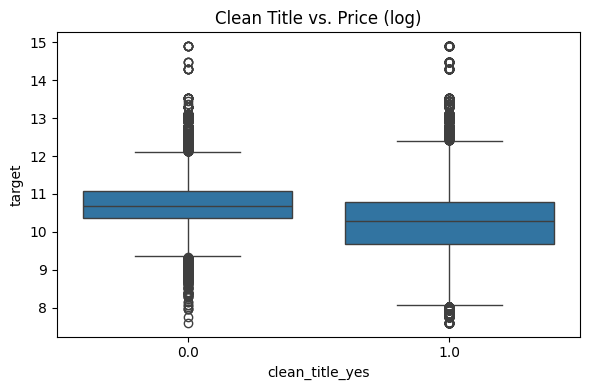

In [469]:
# Plot boxplot to check clean_title_yes vs. price_log
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train_final_with_target, x='clean_title_yes', y='target')
plt.title("Clean Title vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from Clean Title vs. Prcie:**

* Based on the boxplot, cars with clean titles (clean_title_yes = 1) tend to have slightly lower price_log than those without.

* This is unexpected since normally, a clean title should boost the price.

* It can be either due to other factors (like brand or condition) that are driving up the prices of non-clean-title cars.

### 2.3 Histograms and Scatter Plots for Numerical Features

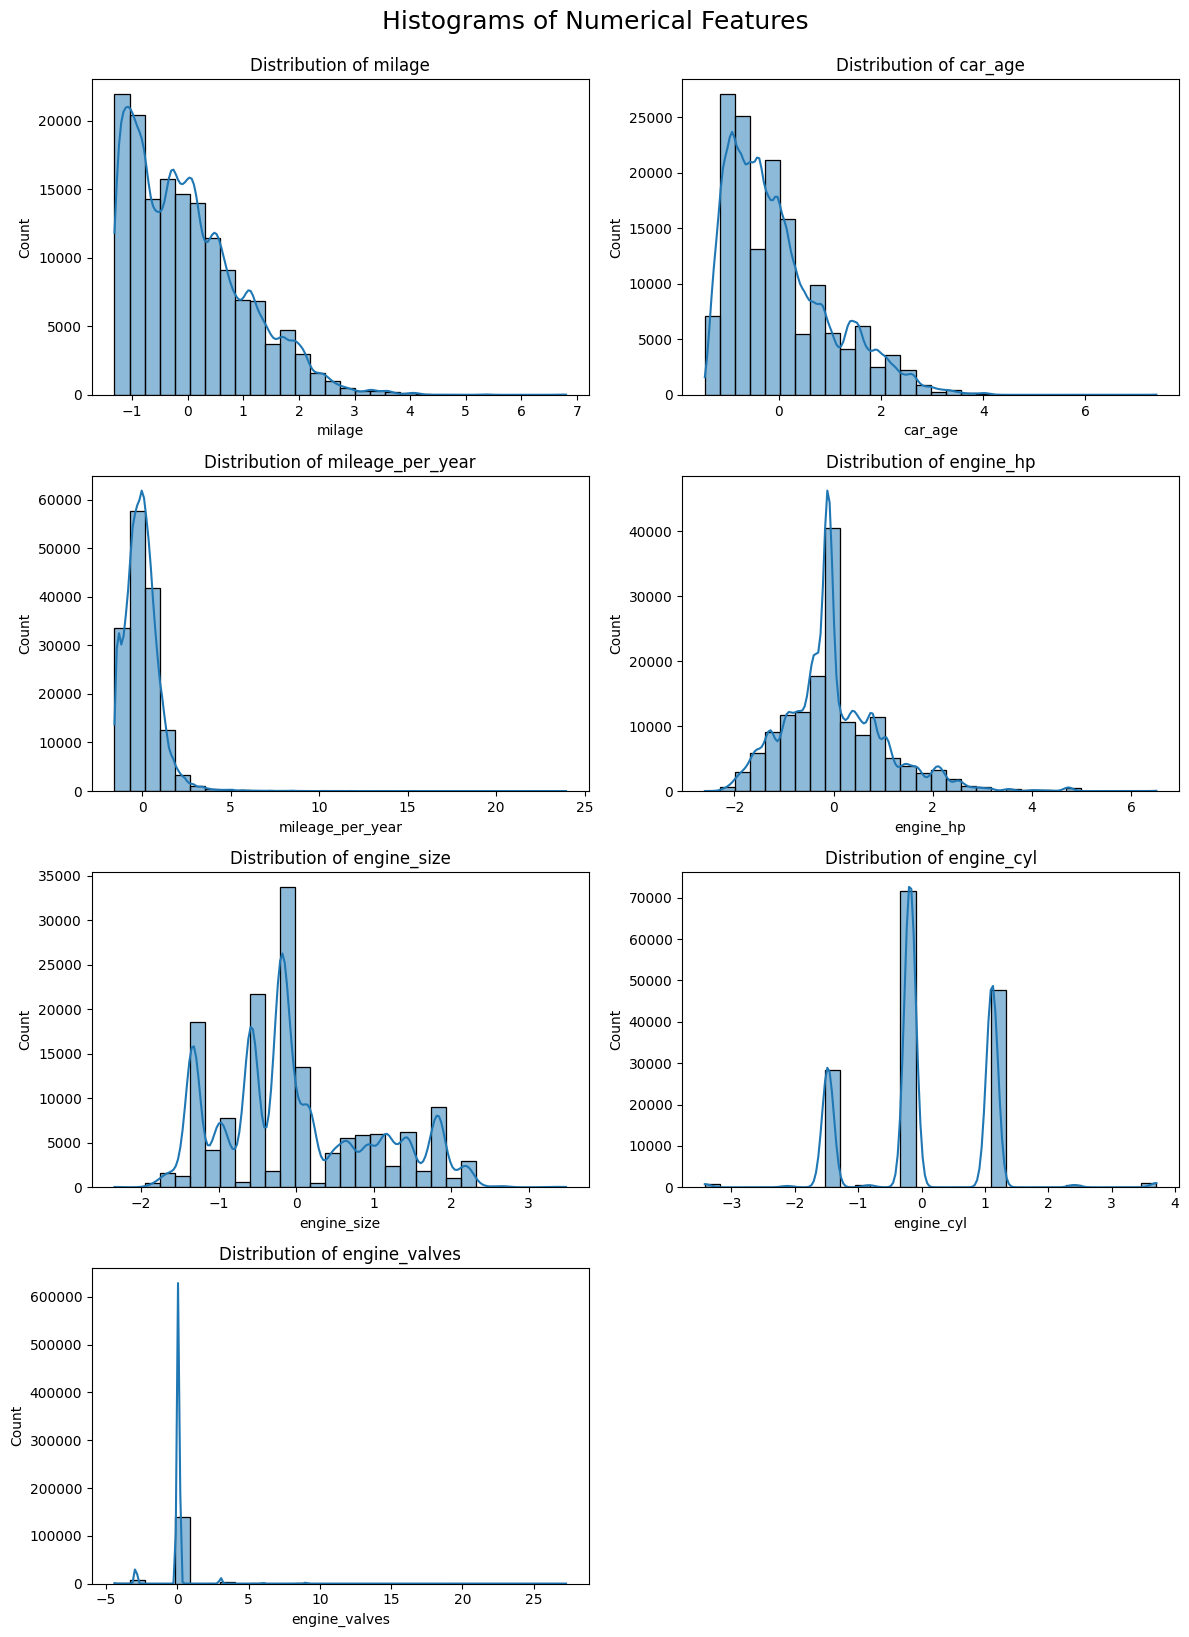

In [470]:
# Select numeric columns excluding binary/dummy features
numeric_cols =['milage',
 'car_age',
 'mileage_per_year',
 'engine_hp',
 'engine_size',
 'engine_cyl',
 'engine_valves']

# Set layout
n_cols = 2
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(numeric_cols):
    sns.histplot(data=X_train_final_with_target, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide unused axes
for ax in axes[len(numeric_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.suptitle("Histograms of Numerical Features", fontsize=18, y=1.02)
plt.show()


**Observation from distribution of numeric features:**

Based on the histogram,

* `milage_log` is right-skewed even after log transformation. Most cars have mileage between 10 and 12 (log scale), indicating high mileage overall.

* `car_age_scaled` is also right-skewed. The majority of cars are relatively new, with a peak around lower age values.

* `engine_hp_scaled` shows a nearly normal distribution but with slight skew and multiple peaks, possibly due to different engine configurations.

* `engine_size_scaled` appears multi-modal with distinct spikes, suggesting common engine sizes (e.g., 2.0L, 3.0L) that dominate the dataset.

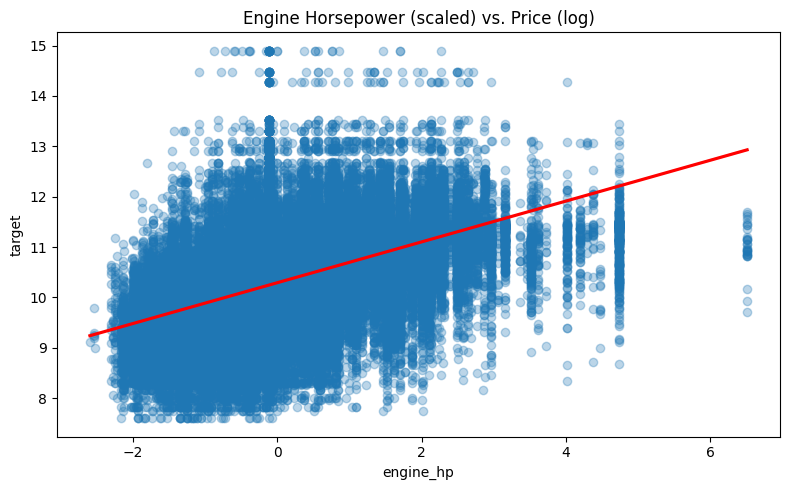

In [474]:
# Plot scatterplot for engine_hp_scaled vs price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='engine_hp', y='target',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title("Engine Horsepower (scaled) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from scatter plot of engine_hp_scaled vs price_log**:

* Based on the scatter plot and regression line, there is a clear positive relationship. As `engine_hp_scaled` increases, `price_log` also tends to rise.

* This is true since horsepower cars are generally priced higher, though there is still some spread due to other influencing factors.

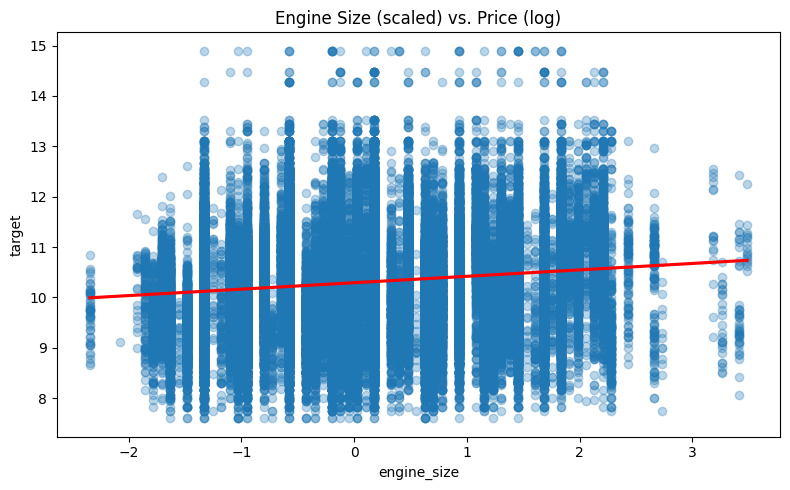

In [475]:
# Plot scatterplot for engine_size vs price_log
plt.figure(figsize=(8, 5))
sns.regplot(data=X_train_final_with_target, x='engine_size', y='target',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title("Engine Size (scaled) vs. Price (log)")
plt.tight_layout()
plt.show()

**Observation from sactter plot of engine_size_scaled vs price_log**

* Based on the scatter plot and regression line, there is a mild positive relationship. As `engine_size_scaled` increases, `price_log` tends to rise slightly.

* The upward trend suggests that larger engines are generally associated with higher prices, but the pattern is more dispersed compared to horsepower.

## 3. Model Building

In [476]:
# Replace white spaces in column names
X_train_final_df.columns = X_train_final_df.columns.str.replace(' ', '_')
X_test_final_df.columns = X_test_final_df.columns.str.replace(' ', '_')

In [477]:
# Convert back to NumPy arrays
X_train_final = X_train_final_df.values
X_test_final = X_test_final_df.values

In [478]:
print(X_train_final.shape)
print(X_test_final.shape)
print(y_train_scaled.shape)
print(y_test_scaled.shape)

(150825, 138)
(37707, 138)
(150825,)
(37707,)


In [479]:
# Fit PCA without limiting components
pca = PCA(random_state=42)
pca.fit(X_train_final)

# Get cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain >= 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

Number of components explaining 95% variance: 33


In [480]:
# Reduce dimensionality coputed principal components
pca = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca = pca.transform(X_test_final)

print(X_train_pca.shape, X_test_pca.shape)

(150825, 33) (37707, 33)


### 3.1 Linear Regression

In [536]:
# Initialize LinearRegression
lr = LinearRegression()

# Train the model
lr.fit(X_train_final, y_train_scaled)

LinearRegression()

In [537]:
# Initialize LinearRegression
lr_pca = LinearRegression()

# Train the model
lr_pca.fit(X_train_pca, y_train_scaled)

LinearRegression()

### 3.2 Ridge Regression

In [534]:
# Initialize Ridge Regression
ridge = Ridge(alpha=1.0)

# Train the model
ridge.fit(X_train_final, y_train_scaled)

Ridge()

In [535]:
# Initialize Ridge Regression
ridge_pca = Ridge(alpha=1.0)

# Train the model
ridge_pca.fit(X_train_pca, y_train_scaled)

Ridge()

### 3.4 XGBoost Regressor (Optional: use LightGBM or any other advanced model)

In [531]:
# Initialize XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train the model
xgb.fit(X_train_final, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [530]:
# Initialize XGBRegressor
xgb_pca = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train the model
xgb_pca.fit(X_train_pca, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### 3.5 LightGBM Regressor

In [528]:
# Initialize LightGBM Regressor
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train the model
lgbm.fit(X_train_final, y_train_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 150825, number of used features: 138
[LightGBM] [Info] Start training from score 10.291456


LGBMRegressor(n_jobs=-1, random_state=42)

In [529]:
# Initialize LightGBM Regressor
lgbm_pca = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# Train the model
lgbm_pca.fit(X_train_pca, y_train_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 150825, number of used features: 33
[LightGBM] [Info] Start training from score 10.291456


LGBMRegressor(n_jobs=-1, random_state=42)

## 4. Model Evaluation

### 4.1 Evaluate each model using:
- R² Score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

In [538]:
# Define function to evaluate models
def evaluate_model(y_true, y_pred, model_name, dataset):

    # Get r2 score
    r2 = r2_score(y_true, y_pred)

    # Get mae
    mae = mean_absolute_error(y_true, y_pred)

    # Get rmse
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Print model name, dataset, and corresponding metrics
    print(f"{model_name} ({dataset} set):")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}\n")

In [539]:
# Evaluate all models
models = {
    "Linear Regression (PCA)": lr_pca,
    "Linear Regression (No PCA)": lr,
    "Ridge Regression (PCA)": ridge_pca,
    "Ridge Regression (No PCA)": ridge,
    "XGBoost (PCA)": xgb_pca,
    "XGBoost (No PCA)": xgb,
    "LightGBM (PCA)": lgbm_pca,
    "LightGBM (No PCA)": lgbm
    # "Random Forest (PCA)": rf_pca,
    # "Random Forest (No PCA)": rf
}

In [574]:
# Define mapping for PCA vs Non-PCA features
feature_sets = {
    "PCA": (X_train_pca, X_test_pca, None),  # no names in PCA
    "No PCA": (X_train_final_df, X_test_final_df, X_train_final_df.columns.tolist())
}

# Evaluate each model
results = []

for name, model in models.items():
    fs_key = "PCA" if "(PCA)" in name else "No PCA"
    X_train_current, X_test_current, feature_names = feature_sets[fs_key]

    # If model supports feature names and they're available, use DataFrame
    if feature_names is not None and hasattr(model, "feature_name_") is False:
        X_train_input = pd.DataFrame(X_train_current, columns=feature_names)
    else:
        X_train_input = X_train_current

    model.fit(X_train_input, y_train_scaled)

    y_train_pred = model.predict(X_train_current)
    y_test_pred = model.predict(X_test_current)

    r2_train = r2_score(y_train_scaled, y_train_pred)
    r2_test = r2_score(y_test_scaled, y_test_pred)
    mae_test = mean_absolute_error(y_test_scaled, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred))

    results.append({
        "Model": name,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
        "MAE Test": mae_test,
        "RMSE Test": rmse_test,
        "Overfit Gap": r2_train - r2_test
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 150825, number of used features: 33
[LightGBM] [Info] Start training from score 10.291456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 150825, number of used features: 138
[LightGBM] [Info] Start training from score 10.291456


In [575]:
# Convert to DataFrame and sort
results_df = pd.DataFrame(results).sort_values("RMSE Test", ascending=True)
display(results_df)

,Model,R2 Train,R2 Test,MAE Test,RMSE Test,Overfit Gap
7,LightGBM (No PCA),0.669076,0.652395,0.346272,0.496306,0.016680
5,XGBoost (No PCA),0.673641,0.651845,0.346598,0.496699,0.021796
4,XGBoost (PCA),0.677421,0.646022,0.350188,0.500835,0.031399
6,LightGBM (PCA),0.669229,0.645403,0.350709,0.501273,0.023825
3,Ridge Regression (No PCA),0.627424,0.619781,0.365423,0.519067,0.007643
1,Linear Regression (No PCA),0.627424,0.619780,0.365427,0.519068,0.007644
2,Ridge Regression (PCA),0.616423,0.608823,0.371460,0.526494,0.007601
0,Linear Regression (PCA),0.616423,0.608823,0.371460,0.526494,0.007601


**Insights from Model Performance Summary:**

* `Linear Regression` and `Ridge` (with or without PCA) perform similarly. R² \~0.61, MAE \~0.37, RMSE \~0.52. Regularization and PCA make no difference. Models underfit.

* `XGBoost (No PCA)` gives R² 0.67 (train), 0.65 (test), with stable MAE and RMSE. Generalizes well.

* `LightGBM (No PCA)` performs best overall. R² 0.67 (train), 0.65 (test), RMSE 0.496. Minimal overfit.

* `PCA` versions of `XGBoost` and `LightGBM` perform slightly worse. Slight drop in R² and increase in RMSE.

* Best models are `XGBoost` and `LightGBM` without PCA. Worst: `Linear` and `Ridge`. PCA adds no value.

## 5. Model Selection

### 5.1 Select the best model based on lowest RMSE and highest R².

In [611]:
# Find the best model based on lowest RMSE
best_row_idx = results_df['RMSE Test'].idxmin()
best_model_name = results_df.loc[best_row_idx, 'Model']
best_model = models[best_model_name]

print("Best model based on RMSE Test:", best_model_name)
print(best_model)

Best model based on RMSE Test: LightGBM (No PCA)
LGBMRegressor(n_jobs=-1, random_state=42)


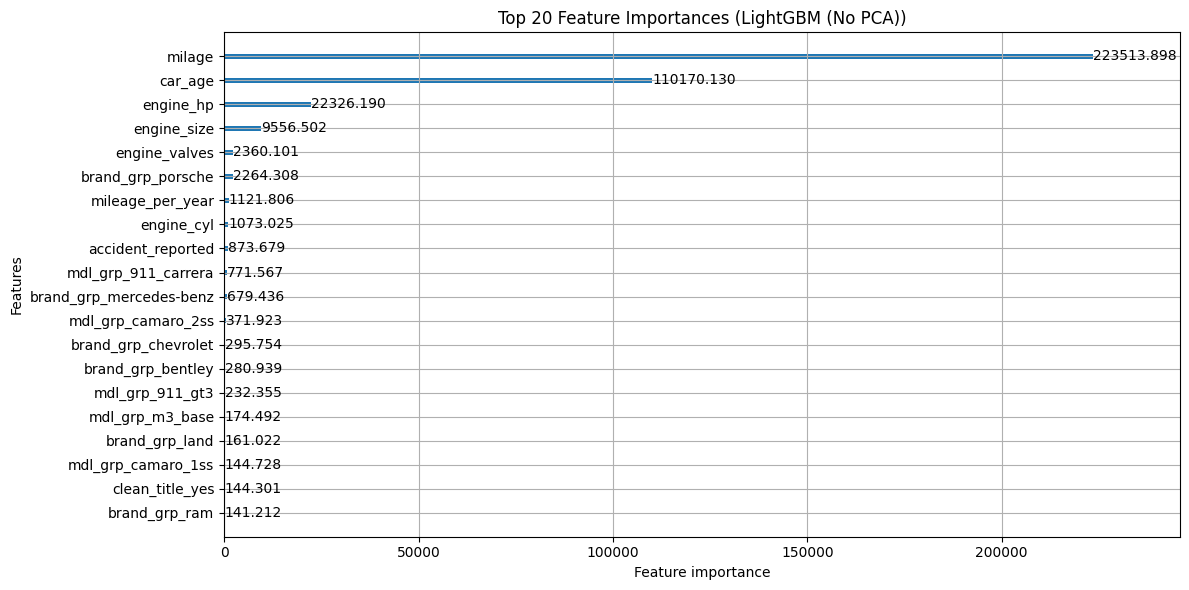

In [612]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

if "No PCA" in best_model_row['Model']:
    plot_importance(best_model,
                    max_num_features=20,
                    importance_type='gain',
                    figsize=(12, 6))
    plt.title(f"Top 20 Feature Importances ({best_model_row['Model']})")
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_row['Model']} used PCA — cannot plot feature importances.")

## 6. Save the Best Model

### 6.1 Use `joblib` or `pickle` to save the best-performing model.

In [614]:
# Save model using pickle
with open(f'best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [615]:
with open('ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)
print("ohe saved.")

with open('num_imputer.pkl', 'wb') as f:
    pickle.dump(num_imputer, f)
print("num_imputer saved.")

with open('num_scaler.pkl', 'wb') as f:
    pickle.dump(num_scaler, f)
print("num_scaler saved.")

ohe saved.
num_imputer saved.
num_scaler saved.


## Prepare for submission

In [617]:
OHE_PATH = "ohe.pkl"
NUM_IMPUTER_PATH = "num_imputer.pkl"
NUM_SCALER_PATH = "num_scaler.pkl"
BEST_MODEL_PATH = "best_model.pkl"
TEST_DATA_PATH = "test_df_cleaned.csv"
SUBMISSION_FILE_NAME = "submission.csv"

# Create the same numerical values defined ealier
numerical_cols = ['milage',
    'car_age',
    'mileage_per_year',
    'engine_hp',
    'engine_size',
    'engine_cyl',
    'engine_valves']

# Step 1: Load test data
test_df_cleaned = pd.read_csv(TEST_DATA_PATH)

# Step 2: Load preprocessing artifacts
with open(OHE_PATH, "rb") as f:
    ohe = pickle.load(f)

with open(NUM_IMPUTER_PATH, "rb") as f:
    num_imputer = pickle.load(f)

with open(NUM_SCALER_PATH, "rb") as f:
    num_scaler = pickle.load(f)

with open(BEST_MODEL_PATH, "rb") as f:
    best_model = pickle.load(f)

# Step 3: Transform test data
X_kaggle_encoded = ohe.transform(test_df_cleaned[ohe.feature_names_in_])
X_kaggle_imputed = num_imputer.transform(test_df_cleaned[numerical_cols])
X_kaggle_scaled = num_scaler.transform(X_kaggle_imputed)
X_kaggle_final = np.hstack([X_kaggle_encoded, X_kaggle_scaled])

# Step 4: Predict and inverse log transformation
y_kaggle_pred_log = best_model.predict(X_kaggle_final)
y_kaggle_pred = np.expm1(y_kaggle_pred_log)

In [622]:
submission['price'] = y_kaggle_pred  # Overwrite placeholder 0s
submission.to_csv('submission.csv', index=False)

## References

* Reade, W. and Chow, A. (2024). Regression of Used Car Prices. [online] Kaggle. Available at: https://www.kaggle.com/competitions/playground-series-s4e9/overview [Accessed 21 Jun. 2025].

* Python Documentation. (2019). datetime — Basic date and time types. [online] Available at: https://docs.python.org/3/library/datetime.html#datetime.date.year [Accessed 16 Jun. 2025].

* Pandas 1.4.1 Documentation. (2025). Options and Settings. [online] Available at: https://pandas.pydata.org/docs/user_guide/options.html [Accessed 16 Jun. 2025].